# Install packages and mount Google-Drive

Run the cell -> click the link -> Login with @gmail.com e-mail account.

In [10]:
%%capture
!pip install pandas matplotlib google-cloud-storage

import os
from google.colab import drive
drive.mount('/content/drive')

# Point environment variable `GOOGLE_APPLICATION_CREDENTIALS` to 
# location of service account file 'dtu-course-02456-students.json'.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/Woodsense/Tech/Software/Deep Learning Course DTU/Students Folder/gcp-service-accounts/dtu-course-02456-students.json"

# Load dataset


In [17]:
import io
import json
import torch
import copy
import pickle
import math
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 25}) 

#Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = 'drive/My Drive/data'
model_path = 'drive/My Drive/'
plot_path = 'drive/My Drive/plots/'

df = pd.read_csv(path + '/woodsense-sensor-data-2020-11-30-cleaned.csv', parse_dates=['timestamp'])

In [ ]:
print("The total number of measurements is {} and {} different features".format(df.shape[0],df.shape[1]))
print("the number of sensors is {}".format(len(pd.unique(df["sensor_id"]))))

The total number of measurements is 85462 and 14 different features
the number of sensors is 66


We notice there are NaN-values. We wish to see how many and which features hav emissing values.

In [ ]:
cols = df.columns.tolist()
cols.append("length")

nanCount = pd.DataFrame(columns=cols)

for id in pd.unique(df["sensor_id"]):
    tmp = [id]
    tmpdf = df[df['sensor_id']==id]
    length = len(tmpdf)
    tmpdf = tmpdf.isna().sum()
    tmp.extend(tmpdf[1:].tolist())
    tmp.append(length)
    nanCount.loc[id] = tmp

pd.set_option('display.max_rows', nanCount.shape[0]+1)
nanCount


sensor_id timestamp  ... weather_precip_past10min length
1          1         0  ...                        0   1678
52        52         0  ...                        0    575
2          2         0  ...                        0    961
53        53         0  ...                        0    418
3          3         0  ...                        0    444
54        54         0  ...                        0    419
4          4         0  ...                        0    864
5          5         0  ...                        0    121
55        55         0  ...                        0    744
6          6         0  ...                        0   1874
7          7         0  ...                        0    864
8          8         0  ...                        0     73
56        56         0  ...                        0    792
9          9         0  ...                        0    861
10        10         0  ...                        0    864
11        11         0  ...                        0     87
57        57         0  ...                        0   2192
12        12         0  ...                        0    864
13        13         0  ...                        0   1879
14        14         0  ...                        0    170
58        58         0  ...                        0   2172
15        15         0  ...                        0   1925
16        16         0  ...                        0    480
59        59         0  ...                        0   1454
17        17         0  ...                        0    864
18        18         0  ...                        0    223
19        19         0  ...                        0   1000
20        20         0  ...                        0   1028
21        21         0  ...                        0   2119
22        22         0  ...                        0   2117
23        23         0  ...                        0   2116
24        24         0  ...                        0   2120
25        25         0  ...                        0   2687
26        26         0  ...                        0   2684
27        27         0  ...                        0   2688
28        28         0  ...                        0    363
29        29         0  ...                        0    967
30        30         0  ...                        0    548
60        60         0  ...                        0     74
31        31         0  ...                        0    180
61        61         0  ...                        0    369
62        62         0  ...                        0     99
32        32         0  ...                        0    967
33        33         0  ...                        0    969
34        34         0  ...                        0   1090
35        35         0  ...                        0   1090
36        36         0  ...                        0   1088
37        37         0  ...                        0   1091
38        38         0  ...                        0   1092
39        39         0  ...                        0   1091
40        40         0  ...                        0   1091
41        41         0  ...                        0   3887
42        42         0  ...                        0   2726
43        43         0  ...                        0   3885
44        44         0  ...                        0   3884
45        45         0  ...                        0    220
46        46         0  ...                        0    670
47        47         0  ...                        0     49
63        63         0  ...                        0    529
64        64         0  ...                        0     97
65        65         0  ...                        0    145
66        66         0  ...                        0    739
48        48         0  ...                        0   3125
49        49         0  ...                        0   3468
50        50         0  ...                        0   3852
51        51         0  ...                

Weather_speed_min is missing for all observations so we will discard this feature. 

# Plot data

Here we plot the different 

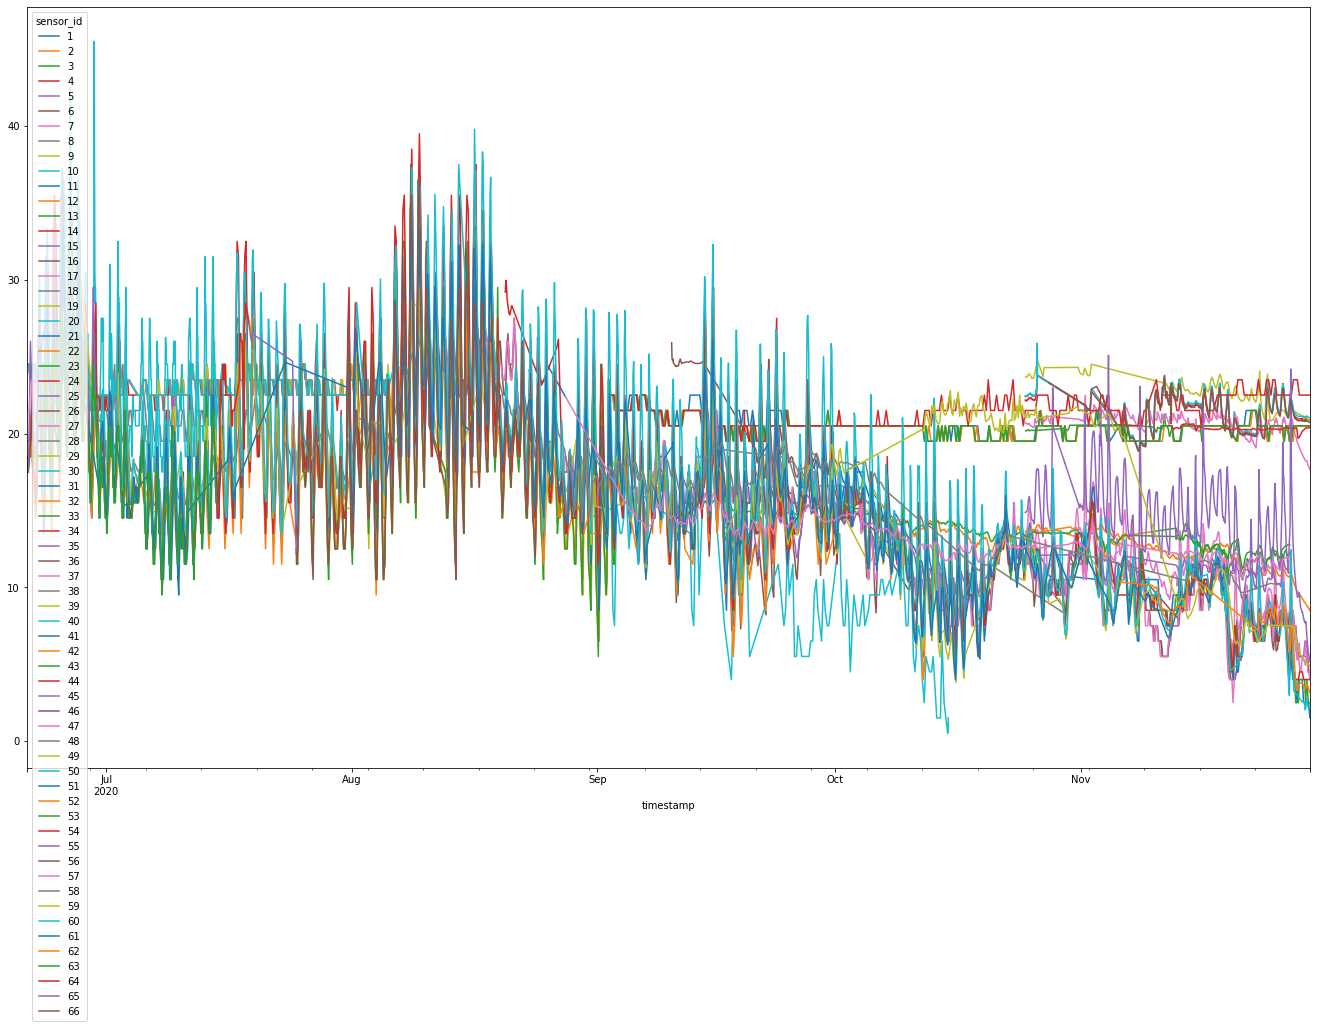

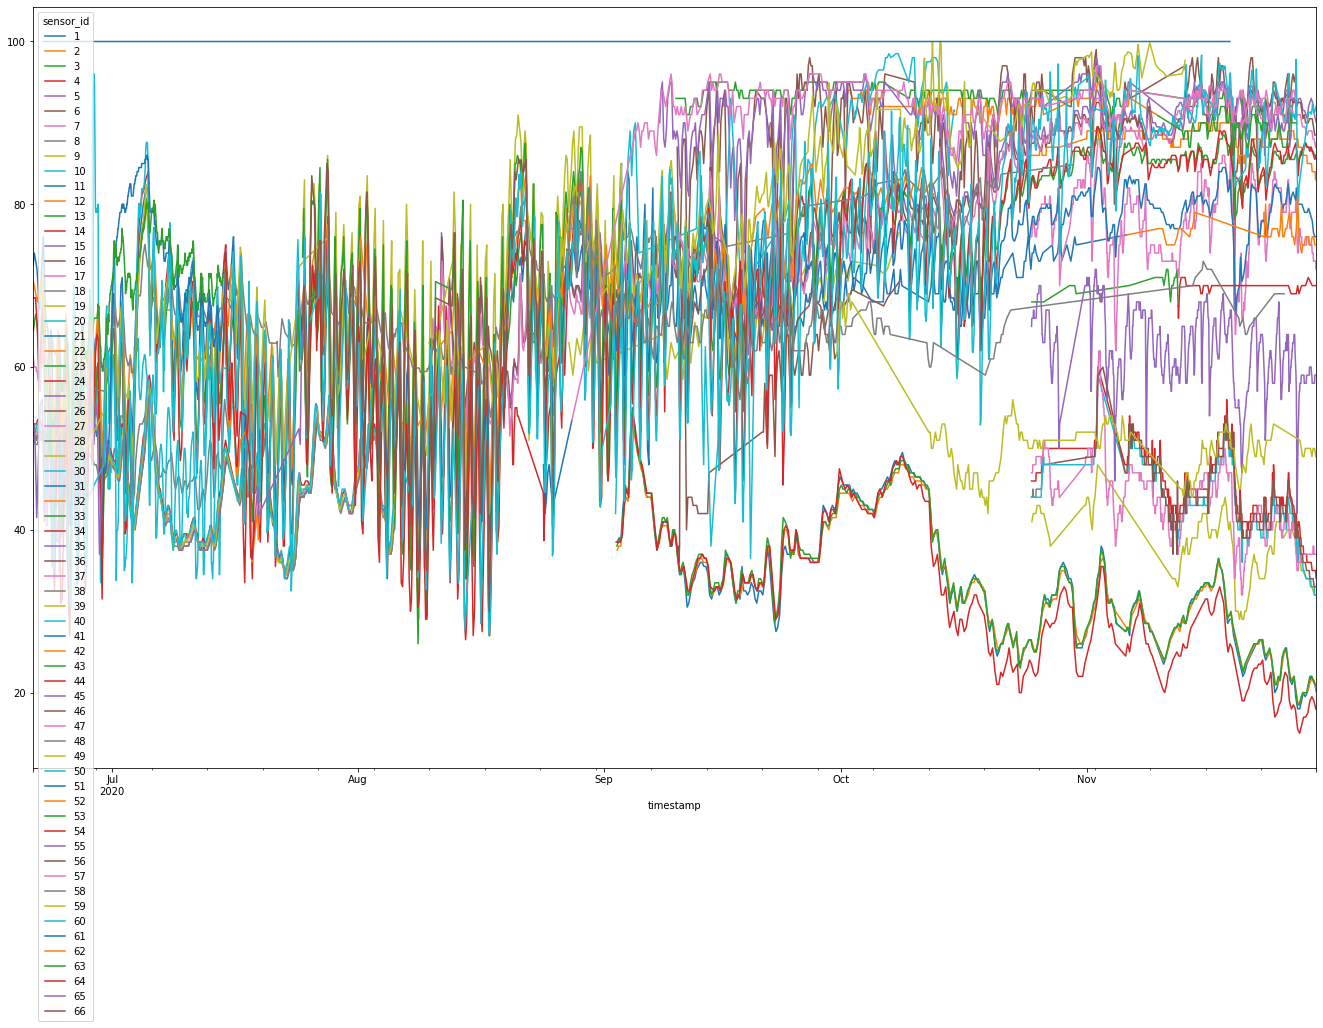

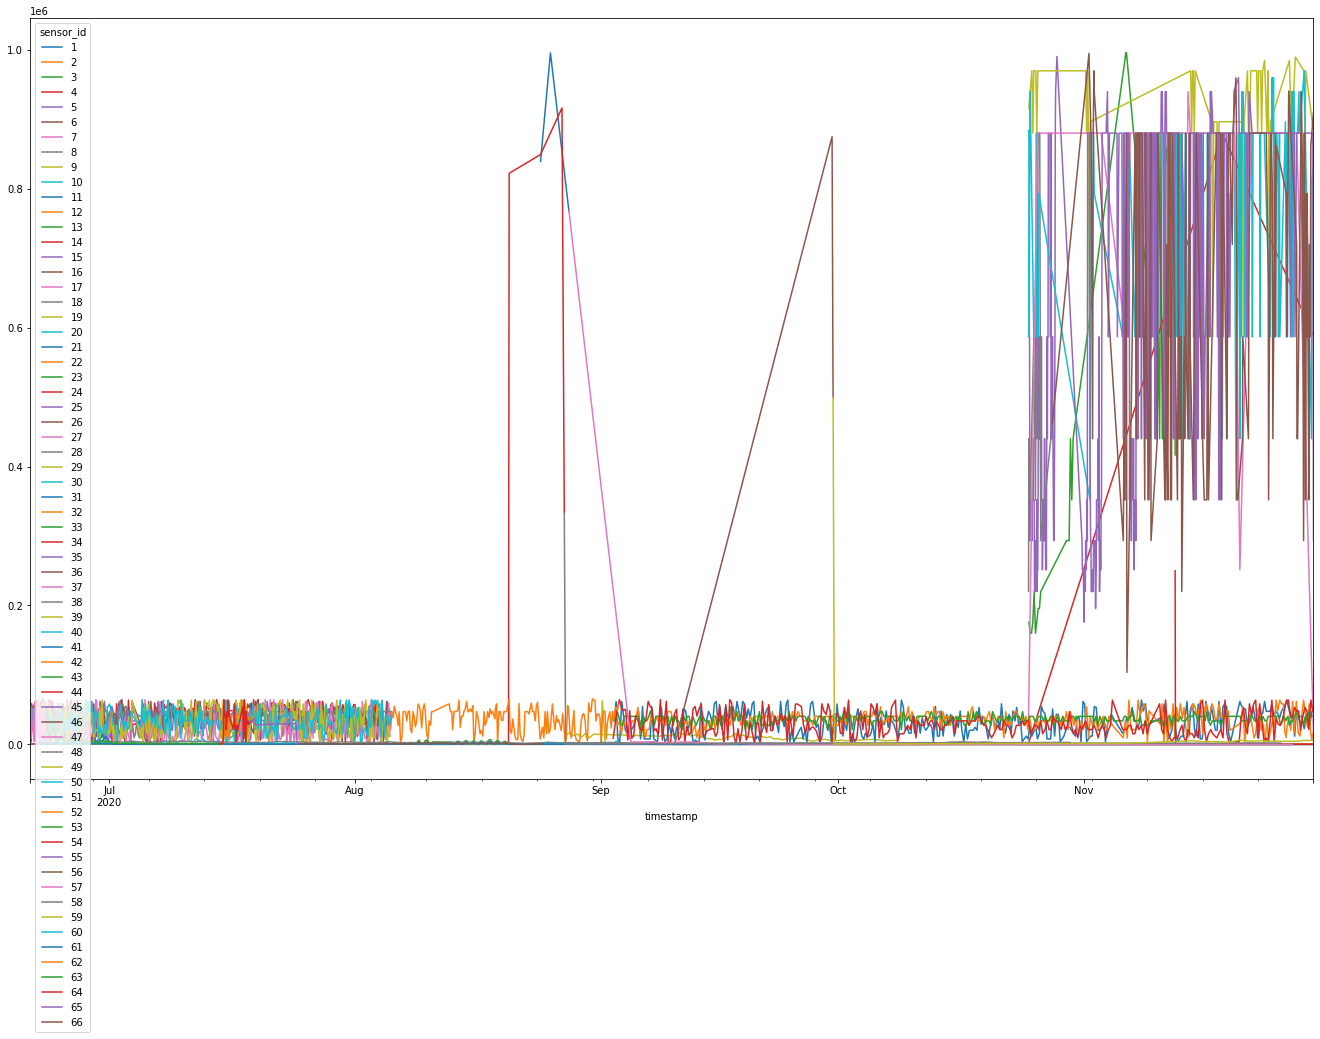

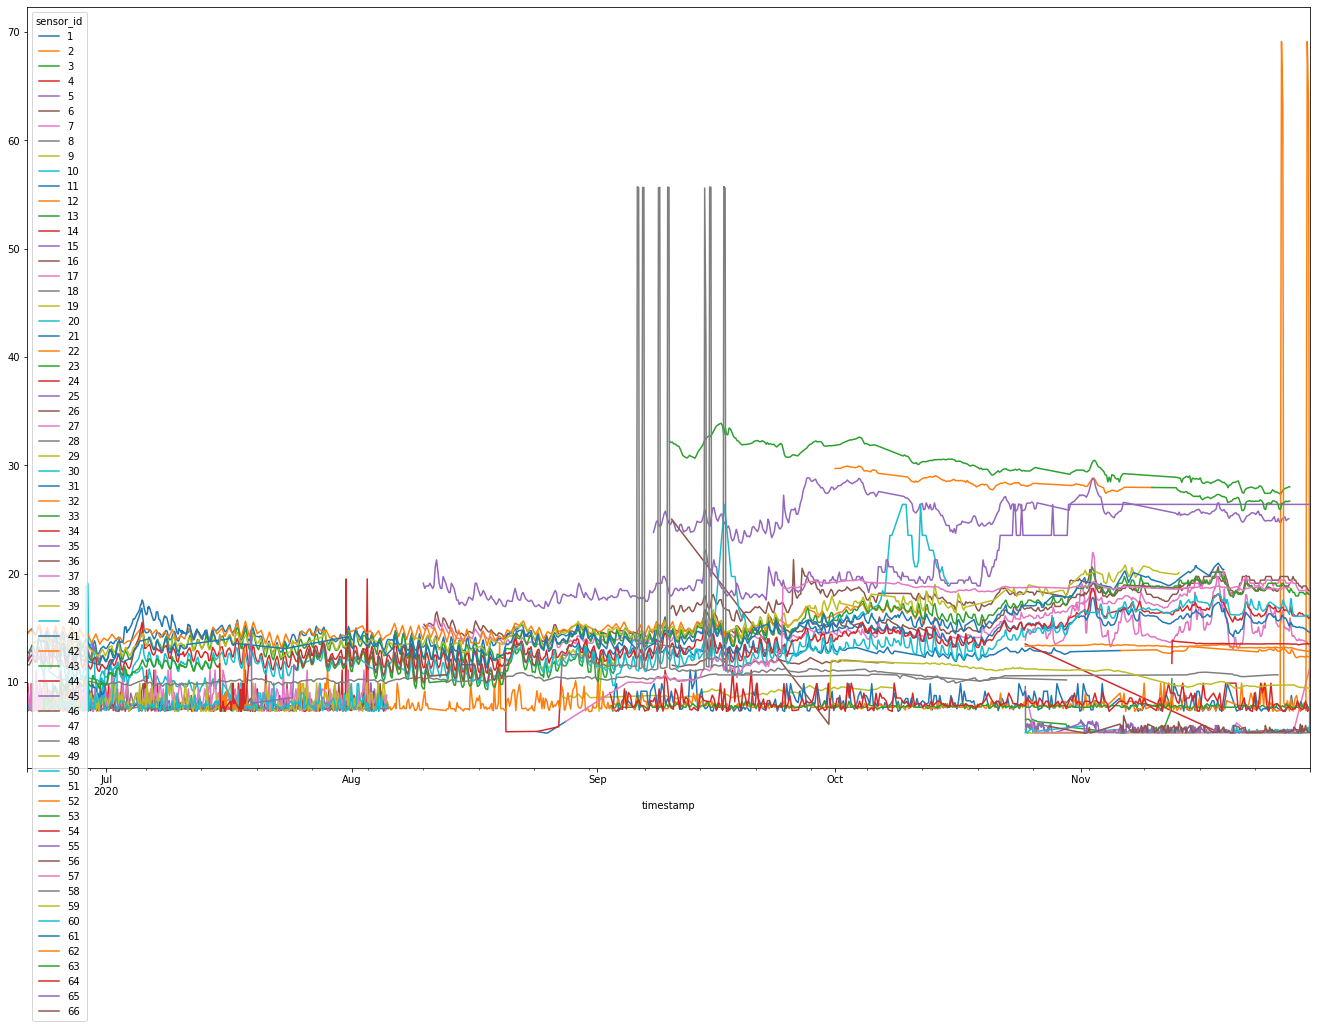

In [ ]:
pivot = df.pivot(index='timestamp', columns='sensor_id', values=['temperature', 'humidity', 'ohms', 'moisture'])
_ = pivot['temperature'].plot(figsize=(23, 14))
_ = pivot['humidity'].plot(figsize=(23, 14))
_ = pivot['ohms'].plot(figsize=(23, 14))
_ = pivot['moisture'].plot(figsize=(23, 14))
#_ = pivot.plot(subplots=True, figsize=(23, 14))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


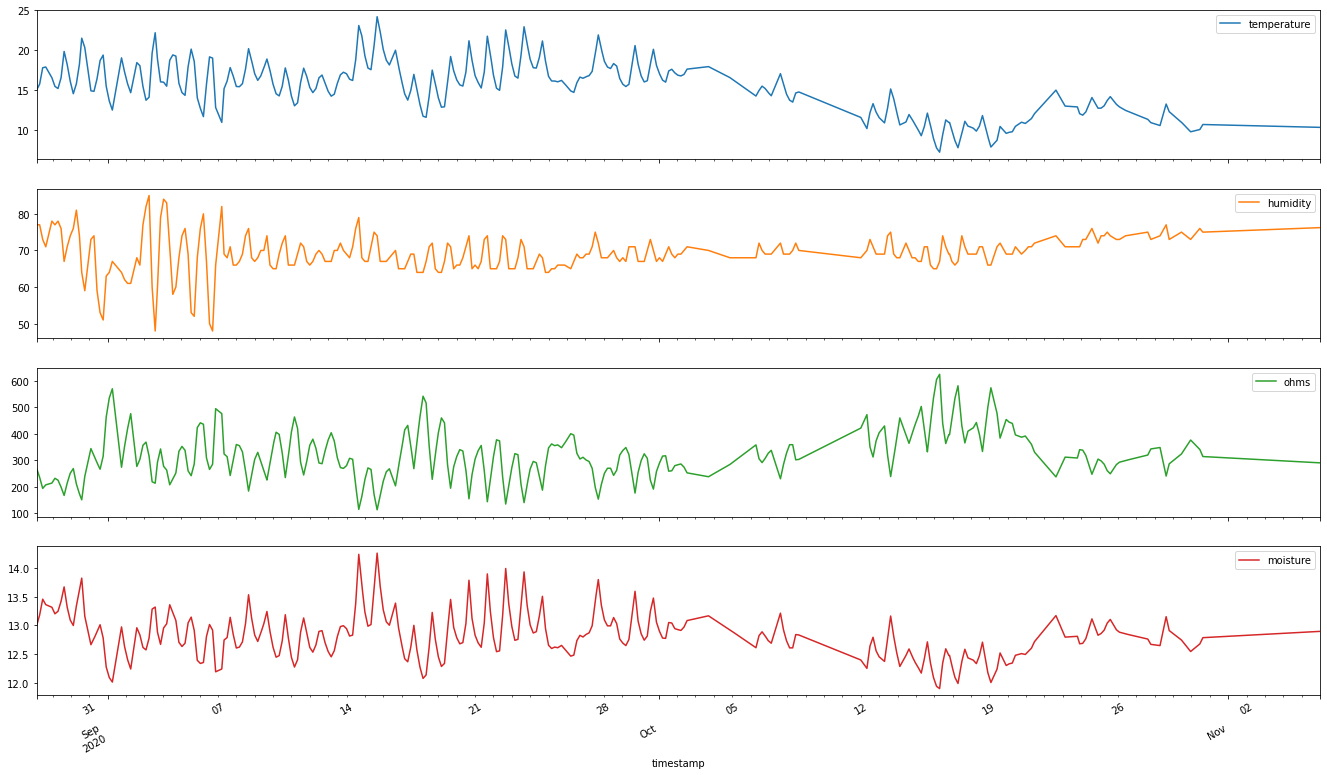

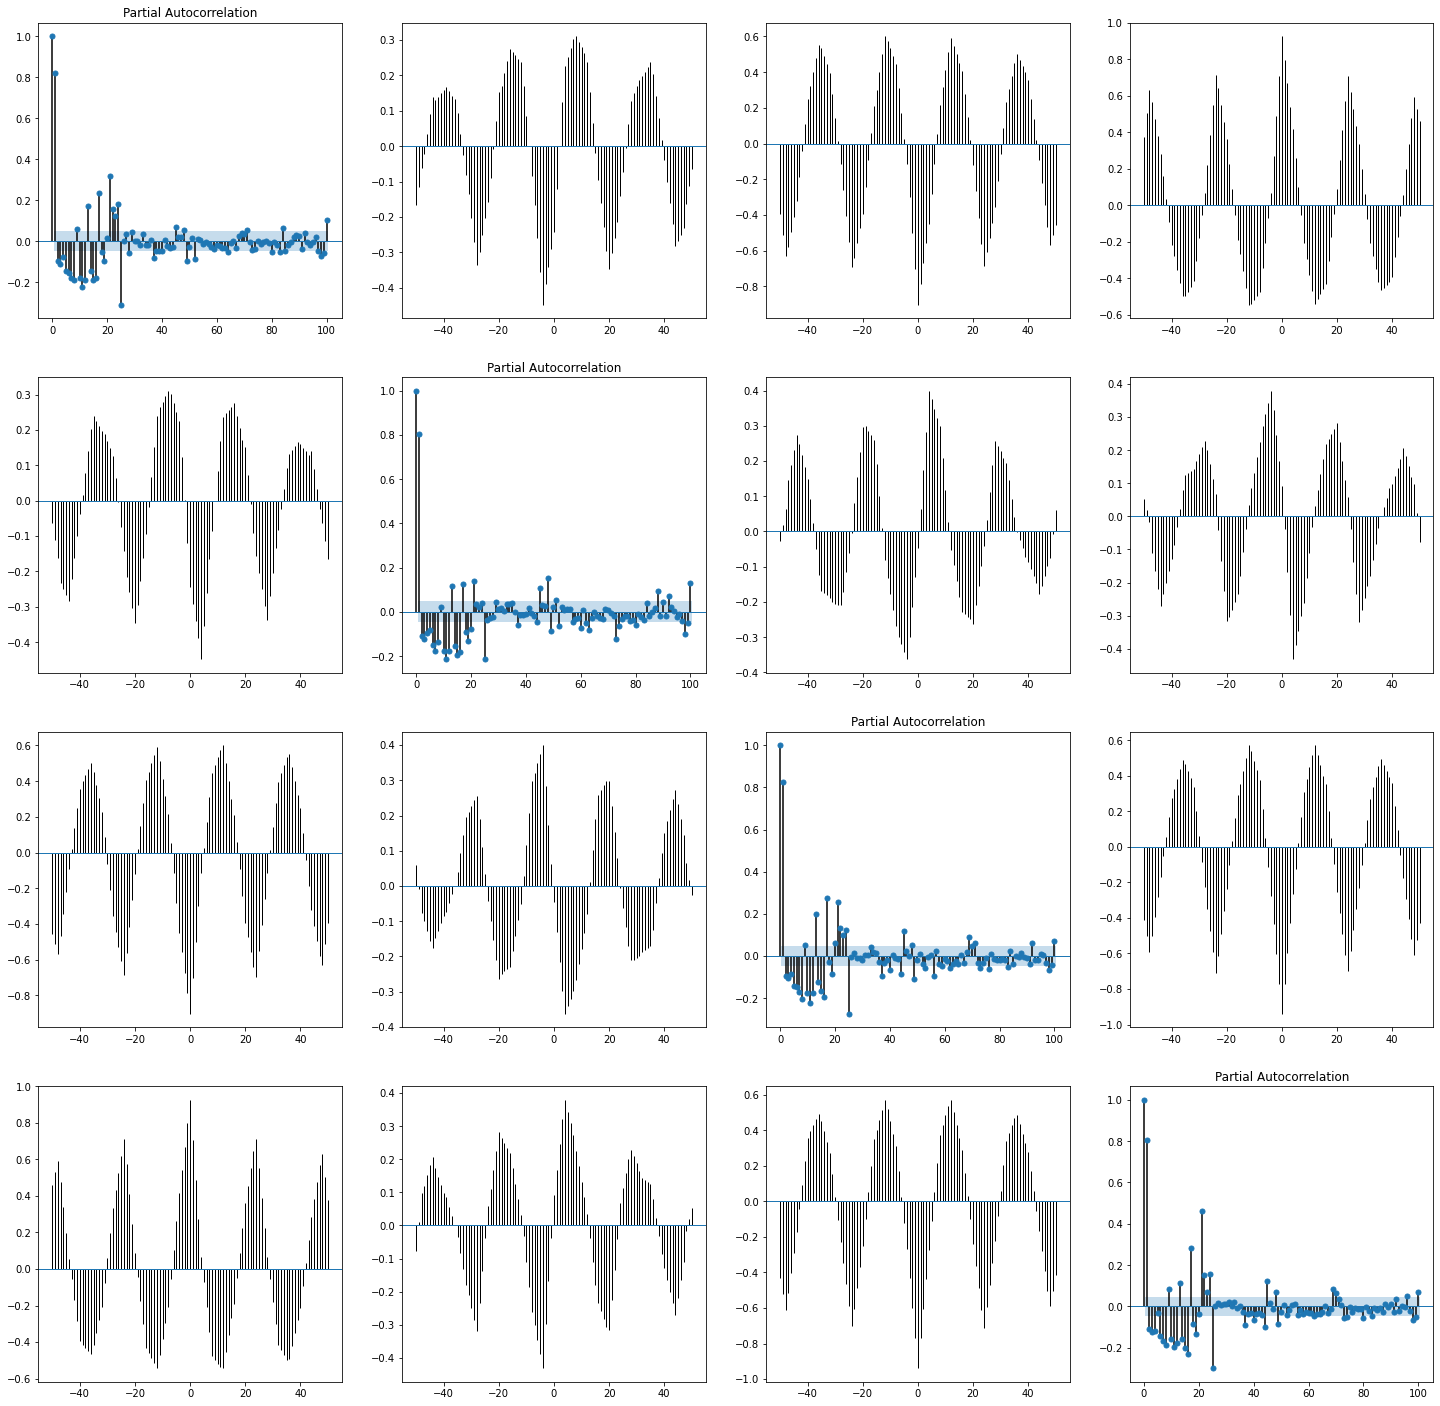

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import time


def plotSensors(id):
  df_sensor_1 = df[df['sensor_id'] == id][['timestamp','temperature', 'humidity', 'ohms', 'moisture']]
  _ = df_sensor_1.set_index('timestamp')[['temperature', 'humidity', 'ohms', 'moisture']].plot(subplots=True, figsize=(23, 14))

  df_sensor_1 = df_sensor_1[['temperature', 'humidity', 'ohms', 'moisture']].diff()[1:]

  fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
    
  _ = plot_pacf(df_sensor_1['temperature'], ax = ax[0][0], use_vlines=True, lags=100, lw=1)
  _ = ax[0][1].xcorr(df_sensor_1['temperature'], df_sensor_1['humidity'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = ax[0][2].xcorr(df_sensor_1['temperature'], df_sensor_1['ohms'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = ax[0][3].xcorr(df_sensor_1['temperature'], df_sensor_1['moisture'], normed=True, usevlines=True, maxlags=50, lw=1)

  _ = ax[1][0].xcorr(df_sensor_1['humidity'], df_sensor_1['temperature'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = plot_pacf(df_sensor_1['humidity'], ax = ax[1][1], use_vlines=True, lags=100, lw=1)
  _ = ax[1][2].xcorr(df_sensor_1['humidity'], df_sensor_1['ohms'], usevlines=True, normed=True, maxlags=50, lw=1)
  _ = ax[1][3].xcorr(df_sensor_1['humidity'], df_sensor_1['moisture'], usevlines=True, normed=True, maxlags=50, lw=1)

  _ = ax[2][0].xcorr(df_sensor_1['ohms'], df_sensor_1['temperature'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = ax[2][1].xcorr(df_sensor_1['ohms'], df_sensor_1['humidity'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = plot_pacf(df_sensor_1['ohms'], ax = ax[2][2], use_vlines=True, lags=100, lw=1)
  _ = ax[2][3].xcorr(df_sensor_1['ohms'], df_sensor_1['moisture'], normed=True, usevlines=True, maxlags=50, lw=1)

  _ = ax[3][0].xcorr(df_sensor_1['moisture'], df_sensor_1['temperature'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = ax[3][1].xcorr(df_sensor_1['moisture'], df_sensor_1['humidity'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = ax[3][2].xcorr(df_sensor_1['moisture'], df_sensor_1['ohms'], normed=True, usevlines=True, maxlags=50, lw=1)
  _ = plot_pacf(df_sensor_1['moisture'], ax = ax[3][3], use_vlines=True, lags=100, lw=1)

plotSensors(1)

# Preprocessing

Seems around 30-50 lags is a good start. We often find few significant lags larger than 30 but it does happen (we would expect about 5 false positives) and some sensors shows signs of seasonality with period about 20. this makes sense as we could expect it to vary along the day so a seasonality of 24 makes sense. Thus making the length a multiple of 24 would make sense. Therefore we decide on a window length 48

In [ ]:
#Map time of day and day of year to features
#df['tod_sin'] = np.sin(df['timestamp'].dt.hour / 24 * 2 * np.pi)
#df['tod_cos'] = np.cos(df['timestamp'].dt.hour / 24 * 2 * np.pi)
#df['doy_sin'] = np.sin(df['timestamp'].dt.dayofyear / 365 * 2 * np.pi)
#df['doy_cos'] = np.cos(df['timestamp'].dt.dayofyear / 365 * 2 * np.pi)

In [ ]:
#Split into train/test based on sensor id. We have 66 sensors. Sensors [20, 25, 26, 27, 50, 51] have been identified by woodsense to be test sensors. We randomly chose 3 and 5 remaining sensors to be test and validation sensors
test_sensors = [20, 25, 26, 27, 50, 51, 12, 42, 17]
validation_sensors = [14, 55, 34, 66, 44]
df_sensor_train = df[(~df['sensor_id'].isin(validation_sensors)) & (~df['sensor_id'].isin(test_sensors))].drop('weather_wind_min',axis=1)
df_sensor_val = df[df['sensor_id'].isin(validation_sensors)].drop('weather_wind_min',axis=1)
df_sensor_test = df[df['sensor_id'].isin(test_sensors)].drop('weather_wind_min',axis=1)

df_sensor_train_features = df_sensor_train.drop(['sensor_id', 'timestamp'],axis=1)
df_sensor_val_features = df_sensor_val.drop(['sensor_id', 'timestamp'],axis=1)
df_sensor_test_features = df_sensor_test.drop(['sensor_id', 'timestamp'],axis=1)

df_sensor_train.head()

sensor_id  ... weather_precip_past10min
0          1  ...                      0.0
1          1  ...                      0.0
2          1  ...                      0.0
3          1  ...                      0.0
4          1  ...                      0.0

[5 rows x 13 columns]

In [ ]:
#Normalize data
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(df_sensor_train_features)

#Normalize the data
df_sensor_train_features_scaled = scaler.transform(df_sensor_train_features)
df_sensor_val_features_scaled = scaler.transform(df_sensor_val_features)
df_sensor_test_features_scaled = scaler.transform(df_sensor_test_features)

#Test transform
print('colwise mean', np.mean(df_sensor_train_features_scaled, axis=0).round(6))
print('colwise variance', np.var(df_sensor_train_features_scaled, axis=0))

cols = df_sensor_train_features.columns

#put the 
df_sensor_train[cols] = df_sensor_train_features_scaled
df_sensor_val[cols] = df_sensor_val_features_scaled
df_sensor_test[cols] = df_sensor_test_features_scaled

df_sensor_train.head()

colwise mean [ 0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


sensor_id  ... weather_precip_past10min
0          1  ...                -0.046488
1          1  ...                -0.046488
2          1  ...                -0.046488
3          1  ...                -0.046488
4          1  ...                -0.046488

[5 rows x 13 columns]

In [ ]:
#Make overlapping windows of length selected above
def temporalize(X, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x 
              n_features)
    '''
    output_X = []
    for i in range(len(X) - lookback + 1):
        t = []
        for j in range(0, lookback):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j)], :])
        output_X.append(t)
    return np.squeeze(np.array(output_X))

window_length = 48
data_train_sequence = []
data_val_sequence = []
data_test_sequence = []
data_train_windowed = []
data_val_windowed = []
data_test_windowed = []

#Run temporalize on each sensor and concatenate the results along rows (axis 0)
for id in pd.unique(df_sensor_train["sensor_id"]):
  tmp = df_sensor_train[df_sensor_train['sensor_id'] == id].to_numpy()
  data_train_sequence.append(tmp)
  
  tmp = temporalize(tmp, window_length)
  data_train_windowed.append(tmp)

data_train_windowed = np.concatenate(data_train_windowed)

#Run temporalize on each sensor and concatenate the results along rows (axis 0)
for id in pd.unique(df_sensor_val["sensor_id"]):
  tmp = df_sensor_val[df_sensor_val['sensor_id'] == id].to_numpy()
  data_val_sequence.append(tmp)

  tmp = temporalize(tmp, window_length)
  data_val_windowed.append(tmp)

data_val_windowed = np.concatenate(data_val_windowed)

#Run temporalize on each sensor and concatenate the results along rows (axis 0)
for id in pd.unique(df_sensor_test["sensor_id"]):
  tmp = df_sensor_test[df_sensor_test['sensor_id'] == id].to_numpy()
  data_test_sequence.append(tmp)

  tmp = temporalize(tmp, window_length)
  data_test_windowed.append(tmp)

data_test_windowed = np.concatenate(data_test_windowed)

print(len(data_train_sequence))
print(len(data_val_sequence))
print(len(data_test_sequence))
print(data_train_sequence[0].shape)
print(data_val_sequence[0].shape)
print(data_test_sequence[0].shape)
print(data_train_windowed.shape)
print(data_val_windowed.shape)
print(data_test_windowed.shape)

52
5
9
(1678, 13)
(744, 13)
(864, 13)
(55402, 48, 13)
(6392, 48, 13)
(20566, 48, 13)


In [ ]:
#create dataset
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        # Return the size of the dataset
        return len(self.inputs)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        X = X[:,2:]
        X = torch.tensor(np.array(list(X[:,:]), dtype=np.float)).float()
        
        return X, X[:,[0,1,3]]

    def getTimestamps(self):
        return self.inputs[:,:,1]

    def getSensors(self):
        return self.inputs[:,:,0]

#Create LSTM dataset
rnnTrainData = Dataset(data_train_sequence)
rnnValData = Dataset(data_val_sequence)
rnnTestData = Dataset(data_test_sequence)

#Create Windowed dataset
windowedTrainData = Dataset(data_train_windowed)
windowedValData = Dataset(data_val_windowed)
windowedTestData = Dataset(data_test_windowed)

x, y = rnnTrainData[0]
print(x.shape)
print(y.shape)
x, y = windowedTrainData[0]
print(x.shape)
print(y.shape)

torch.Size([1678, 11])
torch.Size([1678, 3])
torch.Size([48, 11])
torch.Size([48, 3])


In [ ]:
batch_size = 32
num_epochs = 150

dataloader_train_seq = data.DataLoader(
  dataset=rnnTrainData,
  batch_size=1,
  shuffle=True,
  num_workers=0
)
dataloader_val_seq = data.DataLoader(
  dataset=rnnValData,
  batch_size=1,
  shuffle=False,
  num_workers=0
)
dataloader_test_seq = data.DataLoader(
  dataset=rnnTestData,
  batch_size=1,
  shuffle=False,
  num_workers=0
)
dataloader_train = data.DataLoader(
  dataset=windowedTrainData,
  batch_size=batch_size,
  shuffle=True,
  num_workers=0
)
dataloader_val = data.DataLoader(
  dataset=windowedValData,
  batch_size=batch_size,
  shuffle=False,
  num_workers=0
)
dataloader_test = data.DataLoader(
  dataset=windowedTestData,
  batch_size=batch_size,
  shuffle=False,
  num_workers=0
)

#Train models

## Feed-Forward Model

In [ ]:
class FFNEncoder(nn.Module):
  def __init__(self, num_features, seq_len, hidden_units, latent_features):
    super(FFNEncoder, self).__init__()

    self.seq_len, self.num_features = seq_len, num_features

    self.encoder = nn.Sequential(
        nn.Linear(in_features=num_features*seq_len, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.00022563704212264857),
        # bottleneck layer
        nn.Linear(in_features=hidden_units, out_features=latent_features)
    )


  def forward(self, x):

    x = x.reshape((-1,self.seq_len*self.num_features))

    x = self.encoder(x)

    return x

class FFNDecoder(nn.Module):
  def __init__(self, num_features, seq_len, hidden_units, latent_features):
    super(FFNDecoder, self).__init__()

    self.seq_len, self.num_features = seq_len, num_features

    self.decoder = nn.Sequential(
        nn.Linear(in_features=latent_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.00022563704212264857),
        # output layer, projecting back to image size
        nn.Linear(in_features=hidden_units, out_features=seq_len*num_features)
    )


  def forward(self, x):

    x = self.decoder(x)

    x = x.reshape((-1,self.seq_len,self.num_features))

    return x


class FFNAutoEncoder(nn.Module):
    def __init__(self, num_features, out_features, seq_len, hidden_units, latent_features):
        super(FFNAutoEncoder, self).__init__()

        self.encoder = FFNEncoder(num_features, seq_len, hidden_units, latent_features).to(device)
        self.decoder = FFNDecoder(out_features, seq_len, hidden_units, latent_features).to(device)

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

x, y = windowedTrainData[0]
seq_len, n_features = x.size()
seq_len, out_features = y.size()
modelFFN = FFNAutoEncoder(num_features=n_features, out_features=out_features, seq_len=seq_len, hidden_units=216, latent_features=128)
modelFFN = modelFFN.to(device)

In [ ]:
def train_modelFFN(modelFFN, dataloader_train, dataloader_val, n_epochs):
  optimizer = torch.optim.Adam(modelFFN.parameters(), lr=0.00023597800521918072)
  criterion = nn.L1Loss(reduction='mean').to(device)
  criterion_unreduced = nn.L1Loss(reduction='none').to(device)
  history = dict(train=[], val=[], train_best=[], val_best=[])

  best_model_wts = copy.deepcopy(modelFFN.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    modelFFN = modelFFN.train()

    train_losses = []
    train_losses_unreduced = []
    for inputs, seq_true in dataloader_train:
      optimizer.zero_grad()

      inputs = inputs.to(device)
      seq_true = seq_true.to(device)
      
      seq_pred = modelFFN(inputs)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      loss_unreduced = criterion_unreduced(seq_pred, seq_true)
      train_losses_unreduced.append(loss_unreduced)

    val_losses = []
    val_losses_unreduced = []
    modelFFN = modelFFN.eval()
    with torch.no_grad():
      for inputs, seq_true in dataloader_val:

        inputs = inputs.to(device)
        seq_true = seq_true.to(device)
        seq_pred = modelFFN(inputs)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

        loss_unreduced = criterion_unreduced(seq_pred, seq_true)
        val_losses_unreduced.append(loss_unreduced)

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      history['train_best'] = train_losses_unreduced
      history['val_best'] = val_losses_unreduced
      best_model_wts = copy.deepcopy(modelFFN.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  modelFFN.load_state_dict(best_model_wts)
  return modelFFN.eval(), history

modelFFN, historyFFN = train_modelFFN(
  modelFFN, 
  dataloader_train, 
  dataloader_val, 
  n_epochs=num_epochs
)

torch.save(modelFFN.state_dict(), model_path + 'modelFNN.pth')
with open(model_path + 'historyFFN.pkl', 'wb') as f:
    pickle.dump(historyFFN, f)

Epoch 1: train loss 0.10369113591600718 val loss 0.09263661973178387
Epoch 2: train loss 0.05522381423974698 val loss 0.07442100057378412
Epoch 3: train loss 0.04618690842999184 val loss 0.062339577414095404
Epoch 4: train loss 0.040839603693411615 val loss 0.058028552802279594
Epoch 5: train loss 0.03762730043037315 val loss 0.05175936367828399
Epoch 6: train loss 0.03546164561854568 val loss 0.047977586803026495
Epoch 7: train loss 0.03334896183759834 val loss 0.04589015426114201
Epoch 8: train loss 0.032062447908405414 val loss 0.04458380299154669
Epoch 9: train loss 0.030846644196160327 val loss 0.04420350318774581
Epoch 10: train loss 0.029810924715347433 val loss 0.04336328365840018
Epoch 11: train loss 0.02907940120098566 val loss 0.04190623256377876
Epoch 12: train loss 0.02812414644092459 val loss 0.04144316421356052
Epoch 13: train loss 0.027293784720242437 val loss 0.03984568323940039
Epoch 14: train loss 0.02681674465416623 val loss 0.03910370863974094
Epoch 15: train loss 

In [ ]:
modelFFN.load_state_dict(torch.load(model_path + 'modelFNN.pth'))
modelFFN.eval()
with open(model_path + 'historyFFN.pkl', 'rb') as f:
    historyFFN = pickle.load(f)

## Recurrent model

In [ ]:
class LSTMEncoder(nn.Module):

  def __init__(self, n_features, embedding_dim=64):
    super(LSTMEncoder, self).__init__()

    self.n_features = n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=self.n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=self.embedding_dim,
      num_layers=1,
      batch_first=True
    )

    self.dropout = nn.Dropout(p=0.004672186237821611)

    self.activation = nn.ReLU()

  def forward(self, x):

    x, (embedding_n, _) = self.rnn1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x, (embedding_n, _) = self.rnn2(x)
    out = self.activation(embedding_n)

    return out.squeeze() #batchxembedding_dim

class LSTMDecoder(nn.Module):

  def __init__(self, embedding_dim=64, n_features=1):
    super(LSTMDecoder, self).__init__()

    self.embedding_dim = embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size= self.embedding_dim,
      hidden_size= self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size= self.hidden_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.activation = nn.ReLU()

    self.dropout = nn.Dropout(p=0.004672186237821611)

    self.output_layer = nn.Linear(self.hidden_dim, self.n_features)

  def forward(self, x, seq_len):
    
    x = x.unsqueeze(1).repeat(1, seq_len, 1) #Add a dimension of length 1 in front #batchXseq_lenXembedding_dim

    x, (_, _) = self.rnn1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x, (_, _) = self.rnn2(x) 

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

  def __init__(self, n_features, out_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = LSTMEncoder(n_features, embedding_dim).to(device)
    self.decoder = LSTMDecoder(embedding_dim, out_features).to(device)

  def forward(self, x):
    seq_len = x.size(1)
    x = self.encoder(x)
    x = self.decoder(x, seq_len)

    return x

x, y = windowedTrainData[0]
seq_len, n_features = x.size()
seq_len, out_features = y.size()
modelLSTM = RecurrentAutoencoder(n_features, out_features, 128)
modelLSTM = modelLSTM.to(device)

In [ ]:
def train_modelLSTM(modelLSTM, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(modelLSTM.parameters(), lr=9.80360384835704e-05)
  criterion = nn.L1Loss(reduction='mean').to(device)
  criterion_unreduced = nn.L1Loss(reduction='none').to(device)
  history = dict(train=[], val=[], train_best=[], val_best=[])

  best_model_wts = copy.deepcopy(modelLSTM.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    modelLSTM = modelLSTM.train()

    train_losses = []
    train_losses_unreduced = []
    for inputs, seq_true in dataloader_train:
      optimizer.zero_grad()

      inputs = inputs.to(device)
      seq_true = seq_true.to(device)
      seq_pred = modelLSTM(inputs)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      #torch.nn.utils.clip_grad_norm_(modelLSTM.parameters(),10)
      optimizer.step()

      train_losses.append(loss.item())

      loss_unreduced = criterion_unreduced(seq_pred, seq_true)
      train_losses_unreduced.append(loss_unreduced)

    val_losses = []
    val_losses_unreduced = []
    modelLSTM = modelLSTM.eval()
    with torch.no_grad():
      for inputs, seq_true in dataloader_val:

        inputs = inputs.to(device)
        seq_true = seq_true.to(device)
        seq_pred = modelLSTM(inputs)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

        loss_unreduced = criterion_unreduced(seq_pred, seq_true)
        val_losses_unreduced.append(loss_unreduced)

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      history['train_best'] = train_losses_unreduced
      history['val_best'] = val_losses_unreduced
      best_model_wts = copy.deepcopy(modelLSTM.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  modelLSTM.load_state_dict(best_model_wts)
  return modelLSTM.eval(), history

modelLSTM, historyLSTM = train_modelLSTM(
  modelLSTM, 
  rnnTrainData, 
  rnnValData, 
  n_epochs=num_epochs
)

torch.save(modelLSTM.state_dict(), model_path + 'modelLSTM.pth')
with open(model_path + 'historyLSTM.pkl', 'wb') as f:
    pickle.dump(historyLSTM, f)

Epoch 1: train loss 0.23803555016894126 val loss 0.24901411483064295
Epoch 2: train loss 0.12398836585772643 val loss 0.2364789508469403
Epoch 3: train loss 0.11628524389109353 val loss 0.23391689397394658
Epoch 4: train loss 0.11345383195813065 val loss 0.23493052121251823
Epoch 5: train loss 0.11204924125559886 val loss 0.2297830698080361
Epoch 6: train loss 0.11110863083323967 val loss 0.23203194411471487
Epoch 7: train loss 0.1103221952601166 val loss 0.2291000205464661
Epoch 8: train loss 0.10741161360614018 val loss 0.22124235112220048
Epoch 9: train loss 0.10282300124654663 val loss 0.2164444310963154
Epoch 10: train loss 0.09895067468638302 val loss 0.20812622122466565
Epoch 11: train loss 0.09379527700621867 val loss 0.18640726843848823
Epoch 12: train loss 0.08431113939560245 val loss 0.13849370648153125
Epoch 13: train loss 0.07202876491072065 val loss 0.11686969354748726
Epoch 14: train loss 0.06405062689155547 val loss 0.10580063949339091
Epoch 15: train loss 0.05834292137

In [ ]:
modelLSTM.load_state_dict(torch.load(model_path + 'modelLSTM.pth'))
modelLSTM.eval()
with open(model_path + 'historyLSTM.pkl', 'rb') as f:
    historyLSTM = pickle.load(f)

## Convolutional Model

In [ ]:
class CNNEncoder(nn.Module):
  def __init__(self, num_features, seq_len, hidden_channels, embedding_dim):
    super(CNNEncoder, self).__init__()

    self.seq_len, self.num_features = seq_len, num_features

    self.encoder = nn.Sequential(
        nn.Conv1d(in_channels=num_features, out_channels=hidden_channels, kernel_size=7, padding=3, stride=2),
        nn.ReLU(),
        nn.Dropout(p=0.0005997065346181997),
        nn.Conv1d(in_channels=hidden_channels, out_channels=embedding_dim, kernel_size=7, padding=3, stride=2)
    )


  def forward(self, x):

    x = x.permute(0, 2, 1) #Change to batch X features X seq_len

    x = self.encoder(x)

    return x

class CNNDecoder(nn.Module):
  def __init__(self, num_features, seq_len, hidden_channels, embedding_dim):
    super(CNNDecoder, self).__init__()

    self.seq_len, self.num_features = seq_len, num_features

    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(in_channels=embedding_dim, out_channels=hidden_channels, kernel_size=7, padding=3, stride=2, output_padding=1),
        nn.ReLU(),
        nn.Dropout(p=0.0005997065346181997),
        nn.ConvTranspose1d(in_channels=hidden_channels, out_channels=num_features, kernel_size=7, padding=3, stride=2, output_padding=1)
    )


  def forward(self, x):

    x = self.decoder(x)

    x = x.permute(0, 2, 1) #Change to batch X seq_len X features

    return x


class CNNAutoEncoder(nn.Module):
    def __init__(self, num_features, out_features, seq_len, hidden_channels, embedding_dim):
        super(CNNAutoEncoder, self).__init__()

        self.encoder = CNNEncoder( num_features, seq_len, hidden_channels, embedding_dim).to(device)
        self.decoder = CNNDecoder( out_features, seq_len, hidden_channels, embedding_dim).to(device)

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

x, y = windowedTrainData[0]
seq_len, n_features = x.size()
seq_len, out_features = y.size()
modelCNN = CNNAutoEncoder(num_features=n_features, out_features=out_features, seq_len=seq_len, hidden_channels=11, embedding_dim=36)
modelCNN = modelCNN.to(device)

In [ ]:
def train_modelCNN(modelCNN, dataloader_train, dataloader_val, n_epochs):
  optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.000991727415660136)
  criterion = nn.L1Loss(reduction='mean').to(device)
  criterion_unreduced = nn.L1Loss(reduction='none').to(device)
  history = dict(train=[], val=[], train_best=[], val_best=[])

  best_model_wts = copy.deepcopy(modelCNN.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    modelCNN = modelCNN.train()

    train_losses = []
    train_losses_unreduced = []
    for inputs, seq_true in dataloader_train:
      optimizer.zero_grad()

      inputs = inputs.to(device)
      seq_true = seq_true.to(device)
      seq_pred = modelCNN(inputs)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      loss_unreduced = criterion_unreduced(seq_pred, seq_true)
      train_losses_unreduced.append(loss_unreduced)

    val_losses = []
    val_losses_unreduced = []
    modelCNN = modelCNN.eval()
    with torch.no_grad():
      for inputs, seq_true in dataloader_val:

        inputs = inputs.to(device)
        seq_true = seq_true.to(device)
        seq_pred = modelCNN(inputs)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

        loss_unreduced = criterion_unreduced(seq_pred, seq_true)
        val_losses_unreduced.append(loss_unreduced)

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      history['train_best'] = train_losses_unreduced
      history['val_best'] = val_losses_unreduced
      best_model_wts = copy.deepcopy(modelCNN.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  modelCNN.load_state_dict(best_model_wts)
  return modelCNN.eval(), history

modelCNN, historyCNN = train_modelCNN(
  modelCNN, 
  dataloader_train, 
  dataloader_val, 
  n_epochs=num_epochs
)

torch.save(modelCNN.state_dict(), model_path + 'modelCNN.pth')
with open(model_path + 'historyCNN.pkl', 'wb') as f:
    pickle.dump(historyCNN, f)

Epoch 1: train loss 0.08490505591508078 val loss 0.04740929125342518
Epoch 2: train loss 0.03307275508055098 val loss 0.0357398802600801
Epoch 3: train loss 0.02700470173871252 val loss 0.03371024965308607
Epoch 4: train loss 0.02399503721266245 val loss 0.026753916239831598
Epoch 5: train loss 0.02193971544527825 val loss 0.026913789808750154
Epoch 6: train loss 0.020951022648878447 val loss 0.02369660375174135
Epoch 7: train loss 0.01982111323788315 val loss 0.02288803013274446
Epoch 8: train loss 0.01878333949714073 val loss 0.021849319639150055
Epoch 9: train loss 0.017808933940761256 val loss 0.020257292529568077
Epoch 10: train loss 0.017313008623060018 val loss 0.02127970019588247
Epoch 11: train loss 0.01668052032738322 val loss 0.018115352815948428
Epoch 12: train loss 0.016647865723680884 val loss 0.01613195113372058
Epoch 13: train loss 0.015868103851652413 val loss 0.016426056898199023
Epoch 14: train loss 0.015365326387794821 val loss 0.014934311517281458
Epoch 15: train l

In [ ]:
modelCNN.load_state_dict(torch.load(model_path + 'modelCNN.pth'))
modelCNN.eval()
with open(model_path + 'historyCNN.pkl', 'rb') as f:
    historyCNN = pickle.load(f)

## Transformer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransAutoEncoder(nn.Module):
    def __init__(self, num_features, out_features, d_latent,num_head):
        super(TransAutoEncoder, self).__init__()

        self.pos_encoder = PositionalEncoding(d_latent)

        self.embedding = nn.Linear(num_features, d_latent)

        self.transformer = nn.Transformer(d_model = d_latent, nhead = num_head, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=2048, dropout=0.1)

        self.out = nn.Linear(d_latent, out_features)

    def forward(self, encode, decode,mask):

        encode = self.embedding(encode) #encode.shape = batch X seq_len X d_latent
        decode = self.embedding(decode) #decode.shape = batch X seq_len X d_latent        

        encode = encode.permute(1, 0, 2) #encode.shape = seq_len X batch X d_latent
        decode = decode.permute(1, 0, 2) #decode.shape = seq_len X batch X d_latent

        #Positinal encoding of dimension d_latent
        encode = self.pos_encoder(encode)
        decode = self.pos_encoder(decode)

        out = self.transformer(encode, decode,tgt_mask=mask) #out.shape = seq_len X batch X d_latent mask.shape = seq_len X seq_len

        out = out.permute(1,0,2) #out.shape = batch X seq_len X d_latent

        out = self.out(out) #out.shape = batch X seq_len X out_features
        
        return out

    def generate_square_subsequent_mask(self, sz):
        #Creates a square mask for the sequence. Masked positions are filled with float('-inf'). Unmasked positions are filled with float(0.0).
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

x, y = windowedTrainData[0]
seq_len, n_features = x.size()
seq_len, out_features = y.size()
modelTrans = TransAutoEncoder(num_features=n_features, out_features=out_features, d_latent=4, num_head=4)
modelTrans = modelTrans.to(device)

In [ ]:
def train_modelTrans(modelTrans, dataloader_train, dataloader_val, n_epochs):
  optimizer = torch.optim.Adam(modelTrans.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='mean').to(device)
  criterion_unreduced = nn.L1Loss(reduction='none').to(device)
  history = dict(train=[], val=[], train_best=[], val_best=[])

  best_model_wts = copy.deepcopy(modelTrans.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    modelTrans = modelTrans.train()

    train_losses = []
    train_losses_unreduced = []
    for inputs, seq_true in dataloader_train:
      
      optimizer.zero_grad()

      inputs = inputs.to(device)
      seq_true = seq_true.to(device)
      
      decoder_inputs = torch.zeros(inputs.size(0), 1, inputs.size(2)).to(device)
      decoder_inputs = torch.cat((decoder_inputs,inputs[:,0:-1,:]),dim=1)
      mask = modelTrans.generate_square_subsequent_mask(inputs.size(1)).to(device)

      seq_pred = modelTrans(inputs, decoder_inputs, mask)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      loss_unreduced = criterion_unreduced(seq_pred, seq_true)
      train_losses_unreduced.append(loss_unreduced)

    val_losses = []
    val_losses_unreduced = []
    modelTrans = modelTrans.eval()
    with torch.no_grad():
      for inputs, seq_true in dataloader_val:

        inputs = inputs.to(device)
        seq_true = seq_true.to(device)

        decoder_inputs = torch.zeros(inputs.size(0), 1, inputs.size(2)).to(device)
        decoder_inputs = torch.cat((decoder_inputs,inputs[:,0:-1,:]),dim=1)
        mask = modelTrans.generate_square_subsequent_mask(inputs.size(1)).to(device)

        seq_pred = modelTrans(inputs, decoder_inputs, mask)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

        loss_unreduced = criterion_unreduced(seq_pred, seq_true)
        val_losses_unreduced.append(loss_unreduced)

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      history['train_best'] = train_losses_unreduced
      history['val_best'] = val_losses_unreduced
      best_model_wts = copy.deepcopy(modelTrans.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  modelTrans.load_state_dict(best_model_wts)
  return modelTrans.eval(), history

modelTrans, historyTrans = train_modelTrans(
  modelTrans, 
  dataloader_train, 
  dataloader_val, 
  n_epochs=50
)

torch.save(modelTrans.state_dict(), model_path + 'modelTranstest.pth')
with open(model_path + 'historyTranstest.pkl', 'wb') as f:
    pickle.dump(historyTrans, f)

Epoch 1: train loss 0.25160073980207254 val loss 0.2059089971333742
Epoch 2: train loss 0.15542500929833836 val loss 0.17398402005434035
Epoch 3: train loss 0.14570323571425112 val loss 0.16925498468801378
Epoch 4: train loss 0.1407469039993666 val loss 0.16638102481141687
Epoch 5: train loss 0.13707414785223662 val loss 0.165820607598871
Epoch 6: train loss 0.13537941297933492 val loss 0.16412801448255776
Epoch 7: train loss 0.1335949085128018 val loss 0.16354364985600114
Epoch 8: train loss 0.13264869006380747 val loss 0.16305311007425188
Epoch 9: train loss 0.13160266865294332 val loss 0.16171354247257114
Epoch 10: train loss 0.13088995795567923 val loss 0.16018630865961314
Epoch 11: train loss 0.130354883816033 val loss 0.1625587565265596
Epoch 12: train loss 0.12996547804676495 val loss 0.159841421097517
Epoch 13: train loss 0.12972053716402268 val loss 0.16128947328776122
Epoch 14: train loss 0.12884744863277495 val loss 0.16380969112738966
Epoch 15: train loss 0.1285824872957710

In [ ]:
modelTrans.load_state_dict(torch.load(model_path + 'modelTrans.pth'))
modelTrans.eval()
with open(model_path + 'historyTrans.pkl', 'rb') as f:
    historyTrans = pickle.load(f)

Get reconstruction error for one subseries. For each subseries average reconstruction error in the ensemble. Determine subseries anomalies based on this 

How to make it point based. Each point will be part of l subseries, where l= time window length. Can we just average again?

#Plotting

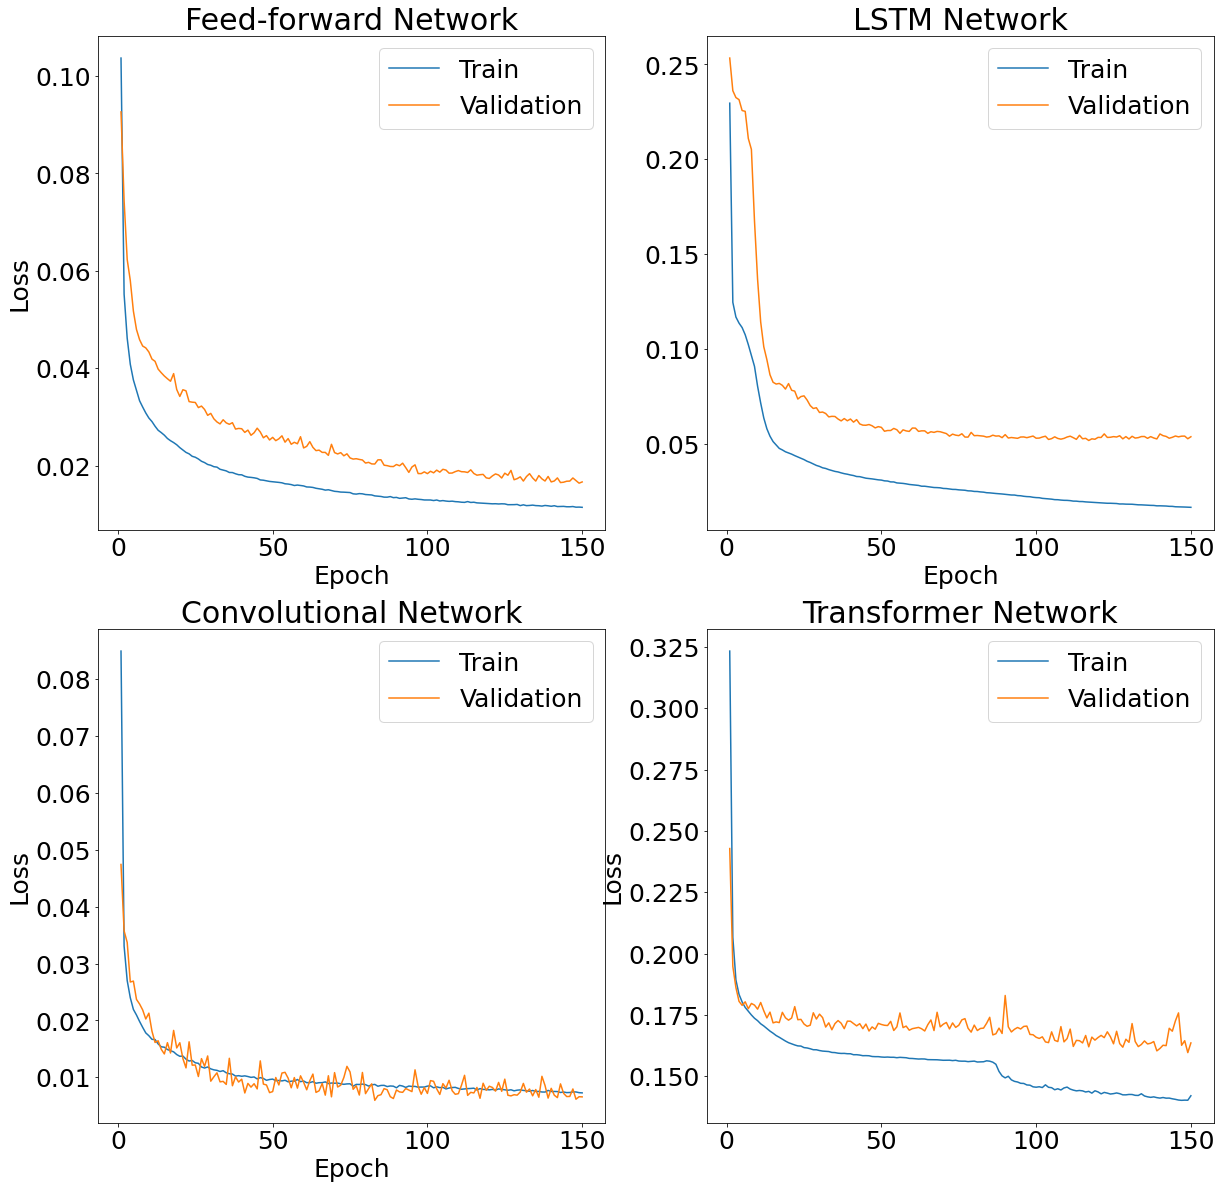

In [ ]:
#The reduced loss vs epoch
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (20,20))
ax[0][0].plot(range(1,num_epochs+1),historyFFN['train'],label='Train')
ax[0][0].plot(range(1,num_epochs+1),historyFFN['val'],label='Validation')
ax[0][0].set_title('Feed-forward Network')
ax[0][0].set_ylabel('Loss')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend()

ax[0][1].plot(range(1,num_epochs+1),historyLSTM['train'],label='Train')
ax[0][1].plot(range(1,num_epochs+1),historyLSTM['val'],label='Validation')
ax[0][1].set_title('LSTM Network')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend()

ax[1][0].plot(range(1,num_epochs+1),historyCNN['train'],label='Train')
ax[1][0].plot(range(1,num_epochs+1),historyCNN['val'],label='Validation')
ax[1][0].set_title('Convolutional Network')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend()

ax[1][1].plot(range(1,num_epochs+1),historyTrans['train'],label='Train')
ax[1][1].plot(range(1,num_epochs+1),historyTrans['val'],label='Validation')
ax[1][1].set_title('Transformer Network')
ax[1][1].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][1].legend()

fname = plot_path + 'trainingCurves.png'
plt.savefig(fname)

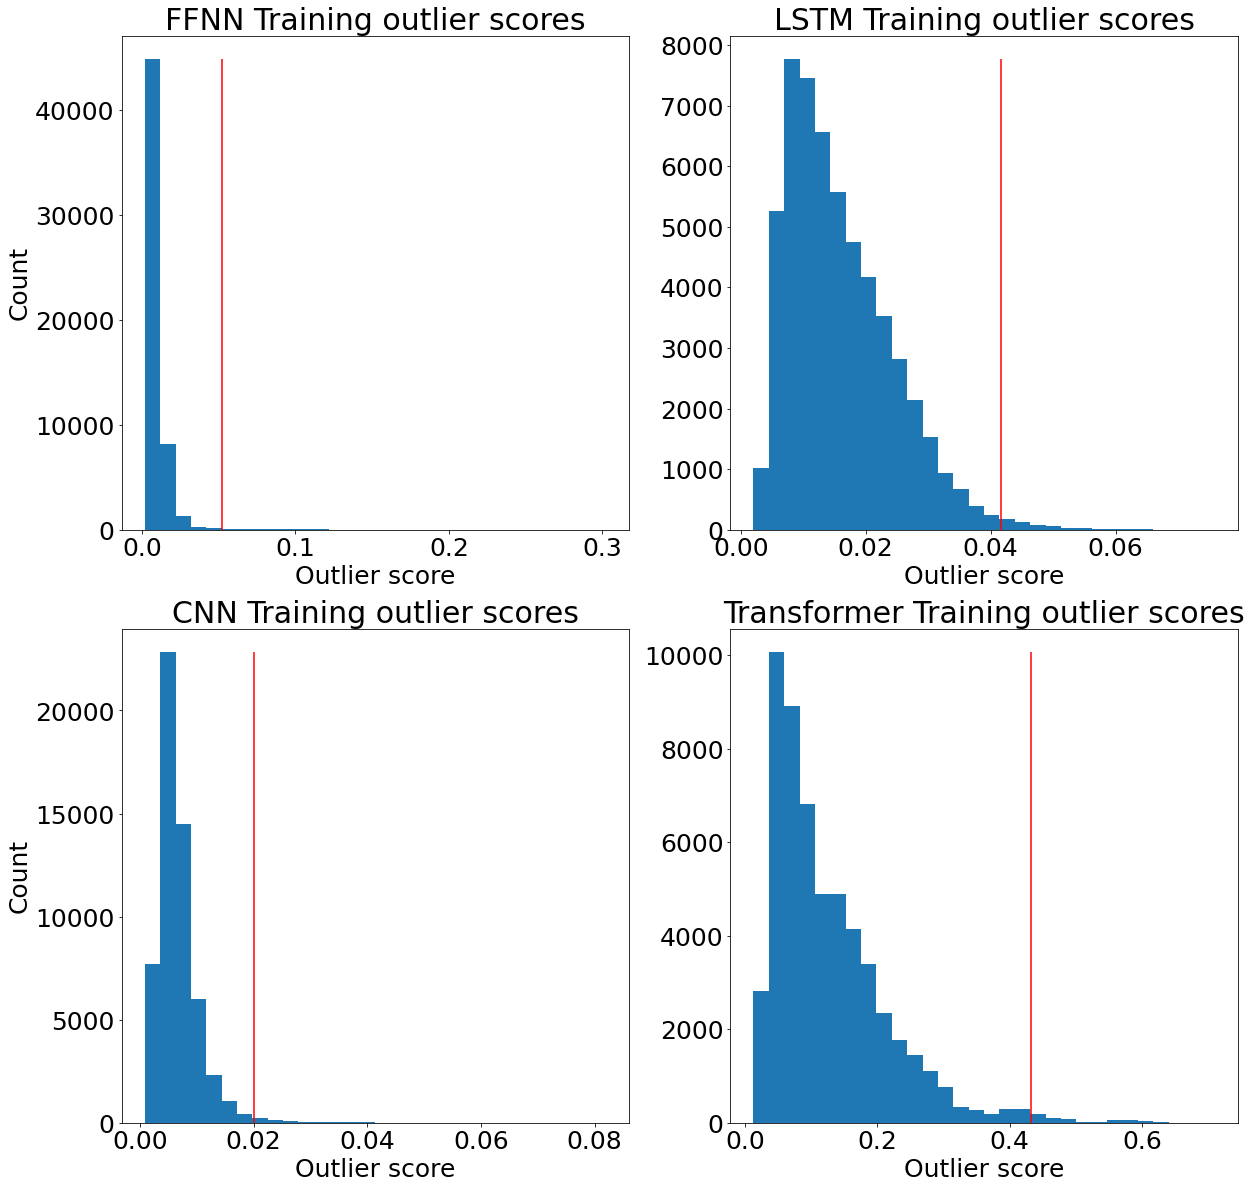

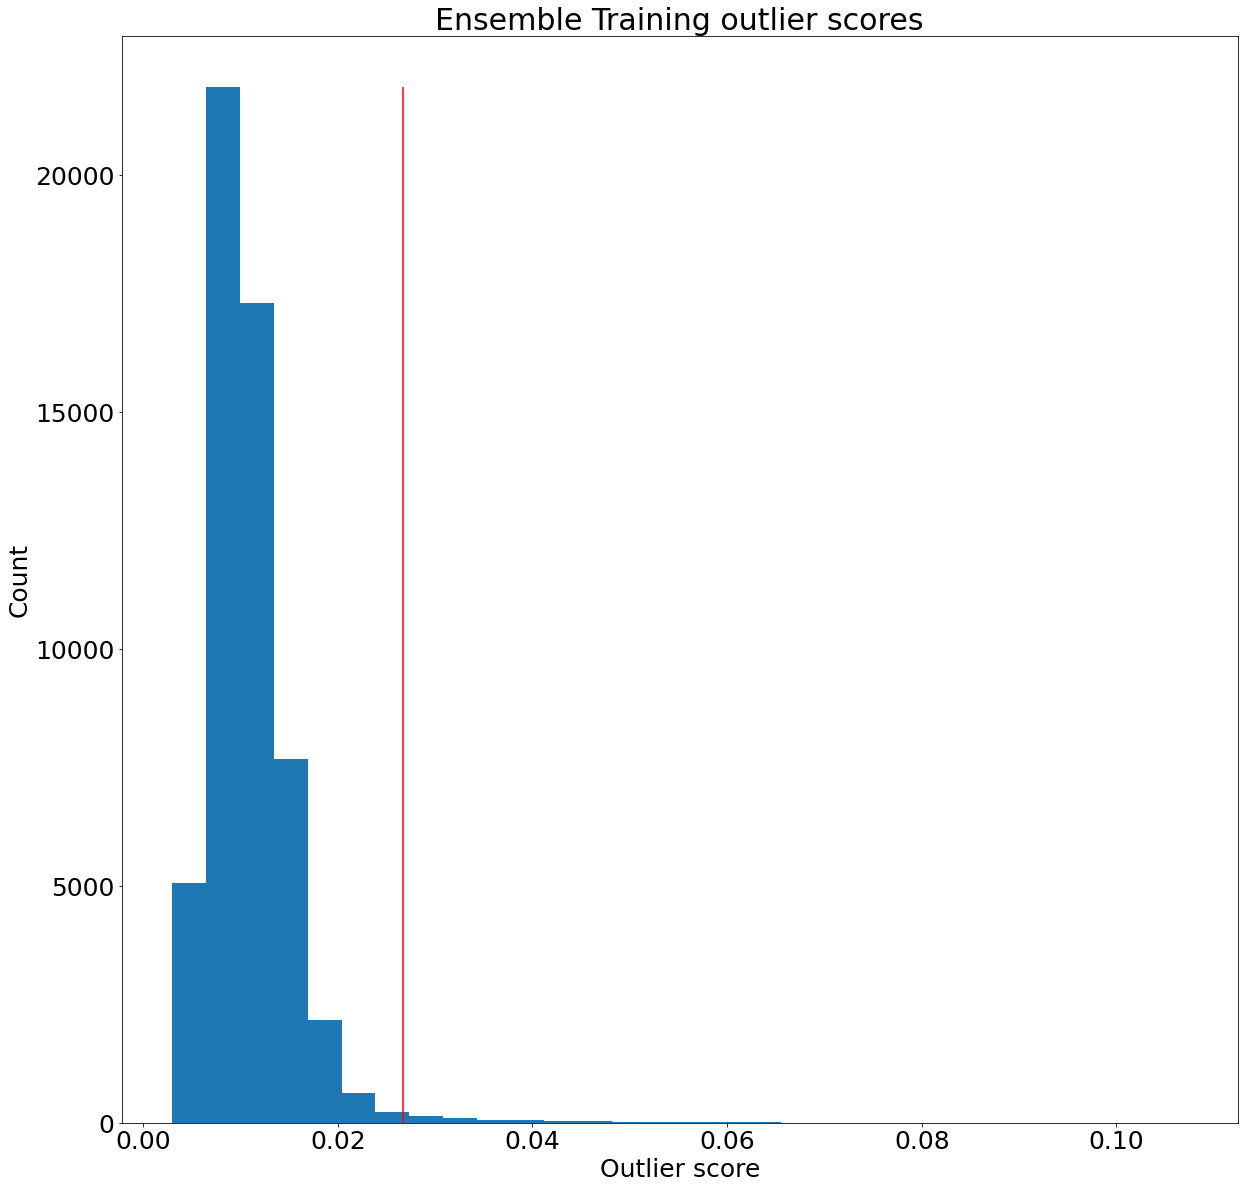

In [ ]:
#Determine outliers

#This has to be rechanged. Insted of using point reconstruction losses use segment reconstruction losses. Use same seq_len as windowed data for ease. 

def windowLoss(loss): #loss samples X win_len X features
  loss = np.mean(loss,axis=2)
  loss = np.median(loss, axis = 1)

  return loss

#For LSTM sequence
#lossesLSTM = []
#for seq in historyLSTM['train_best']:
#  seq_temp = np.squeeze(seq.cpu().detach().numpy())
#  seq_temp = temporalize(seq_temp,window_length)
#  
#  loss_tmp = windowLoss(seq_temp)
#  
#  lossesLSTM.extend(loss_tmp)
#
#lossesLSTM = np.array(lossesLSTM)
#threshold_LSTM = np.quantile(lossesLSTM,0.99)

lossesLSTM = windowLoss(torch.cat(historyLSTM['train_best'], 0).cpu().detach().numpy()) #Cat batches before using windowLoss
threshold_LSTM = np.quantile(lossesLSTM,0.99)

#For other
lossesFFN = windowLoss(torch.cat(historyFFN['train_best'], 0).cpu().detach().numpy()) #Cat batches before using windowLoss
threshold_FFN = np.quantile(lossesFFN,0.99)

lossesCNN = windowLoss(torch.cat(historyCNN['train_best'], 0).cpu().detach().numpy()) #Cat batches before using windowLoss
threshold_CNN = np.quantile(lossesCNN,0.99)

lossesTrans = windowLoss(torch.cat(historyTrans['train_best'], 0).cpu().detach().numpy()) #Cat batches before using windowLoss
threshold_Trans = np.quantile(lossesTrans,0.99)

#For ensemble
#For each timestep average loss over ensemble members
lossesEnsemble = np.mean(np.vstack((lossesFFN, lossesCNN, lossesLSTM)), axis=0)
threshold_Ensemble = np.quantile(lossesEnsemble,0.99)
#threshold_Ensemble = np.mean([threshold_LSTM, threshold_FFN, threshold_CNN, threshold_Trans])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

countsFFN, _, _ = ax[0][0].hist(lossesFFN, bins=30)
ax[0][0].vlines(threshold_FFN,0,np.max(countsFFN),colors='r')
ax[0][0].set_xlabel("Outlier score")
ax[0][0].set_ylabel("Count")
ax[0][0].set_title("FFNN Training outlier scores")
countsLSTM, _, _ = ax[0][1].hist(lossesLSTM, bins=30)
ax[0][1].vlines(threshold_LSTM,0,np.max(countsLSTM),colors='r')
ax[0][1].set_xlabel("Outlier score")
ax[0][1].set_title("LSTM Training outlier scores")
countsCNN, _, _ = ax[1][0].hist(lossesCNN, bins=30)
ax[1][0].vlines(threshold_CNN,0,np.max(countsCNN),colors='r')
ax[1][0].set_xlabel("Outlier score")
ax[1][0].set_ylabel("Count")
ax[1][0].set_title("CNN Training outlier scores")
countsTrans, _, _ = ax[1][1].hist(lossesTrans, bins=30)
ax[1][1].vlines(threshold_Trans,0,np.max(countsTrans),colors='r')
ax[1][1].set_xlabel("Outlier score")
ax[1][1].set_title("Transformer Training outlier scores")

fname = plot_path + 'trainingOutlierScoresMembers.png'
plt.savefig(fname)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,20))
counts, _, _ = ax.hist(lossesEnsemble, bins=30)
ax.vlines(threshold_Ensemble,0,np.max(counts),colors='r')
ax.set_xlabel("Outlier score")
ax.set_ylabel("Count")
ax.set_title("Ensemble Training outlier scores")

fname = plot_path + 'trainingOutlierScoresEnsemblesQuantileRegression.png'
plt.savefig(fname)


#Testing

In [ ]:
#Test loop
def predict(model, dataset):
  criterion = nn.L1Loss(reduction='none').to(device)
  predictions, losses = [], []
  with torch.no_grad():
    model.eval()
    for inputs, seq_true in dataset:
      inputs = inputs.to(device)
      seq_true = seq_true.to(device)
      seq_pred = model(inputs)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred)
      losses.append(loss)
  
  predictions = torch.cat(predictions, 0)
  losses = torch.cat(losses, 0)

  return predictions, losses

def predictTrans(model, dataset):
  criterion = nn.L1Loss(reduction='none').to(device)
  predictions, losses = [], []
  with torch.no_grad():
    model.eval()
    for inputs, seq_true in dataset:

      inputs = inputs.to(device)
      seq_true = seq_true.to(device)
      
      decoder_inputs = torch.zeros(inputs.size(0), 1, inputs.size(2)).to(device)
      decoder_inputs = torch.cat((decoder_inputs,inputs[:,0:-1,:]),dim=1)
      mask = model.generate_square_subsequent_mask(inputs.size(1)).to(device)

      seq_pred = model(inputs, decoder_inputs, mask)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred)
      losses.append(loss)
  
  predictions = torch.cat(predictions, 0)
  losses = torch.cat(losses, 0)

  return predictions, losses

#Create test data
predictionsFFN = []
predictionsLSTM = []
predictionsCNN = []
predictionsTrans = []
lossesFFN = []
lossesLSTM = []
lossesCNN = []
lossesTrans = []
lossesEnsemble = []
anomaliesFFN = []
anomaliesLSTM = []
anomaliesCNN = []
anomaliesTrans = []
anomaliesEnsemble = []
timestamps = []
data_full = []
data_temporalize =  []
for sensor_id in test_sensors:
  data_full_sensor = df_sensor_test[df_sensor_test['sensor_id'] == sensor_id].to_numpy()
  data_temporalize_sensor = temporalize(data_full_sensor, window_length)
  data_sequence = np.expand_dims(data_full_sensor, axis=0)

  rnnData = Dataset(data_sequence)
  windowedData = Dataset(data_temporalize_sensor)
  dataloader = data.DataLoader(
    dataset=windowedData,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
  )
  dataloader_rnn = data.DataLoader(
    dataset=rnnData,
    batch_size=1,
    shuffle=False,
    num_workers=0
  )

  timestamp = np.array(windowedData.getTimestamps())

  #Run predictions
  predictionFFN, lossFFN = predict(modelFFN, dataloader)
  predictionLSTM, lossLSTM = predict(modelLSTM, dataloader)
  predictionCNN, lossCNN = predict(modelCNN, dataloader)
  predictionTrans, lossTrans = predictTrans(modelTrans, dataloader)

  #Temporalize LSTM predictions
  #predictionsLSTM = np.squeeze(predictionsLSTM.cpu().detach().numpy())
  #predictionsLSTM = temporalize(predictionsLSTM,window_length)
  #lossesLSTM = np.squeeze(lossesLSTM.cpu().detach().numpy())
  #lossesLSTM = temporalize(lossesLSTM,window_length)

  # Convert others to numpy
  predictionFFN = predictionFFN.cpu().detach().numpy()
  predictionLSTM = predictionLSTM.cpu().detach().numpy()
  predictionCNN = predictionCNN.cpu().detach().numpy()
  predictionTrans = predictionTrans.cpu().detach().numpy()
  lossFFN = lossFFN.cpu().detach().numpy()
  lossLSTM = lossLSTM.cpu().detach().numpy()
  lossCNN = lossCNN.cpu().detach().numpy()
  lossTrans = lossTrans.cpu().detach().numpy()


  #Determine anomalies
  lossFFN = windowLoss(lossFFN)
  lossLSTM = windowLoss(lossLSTM)
  lossCNN = windowLoss(lossCNN)
  lossTrans = windowLoss(lossTrans)
  lossEnsemble = np.mean(np.vstack((lossFFN, lossCNN, lossLSTM)), axis=0)

  anomalyFFN = np.asarray(lossFFN > threshold_FFN)
  anomalyLSTM = np.asarray(lossLSTM > threshold_LSTM)
  anomalyCNN = np.asarray(lossCNN > threshold_CNN)
  anomalyTrans = np.asarray(lossTrans > threshold_Trans)
  anomalyEnsemble = np.asarray(lossEnsemble > threshold_Ensemble)

  predictionsFFN.append(predictionFFN)
  predictionsLSTM.append(predictionLSTM)
  predictionsCNN.append(predictionCNN)
  predictionsTrans.append(predictionTrans)
  lossesFFN.append(lossFFN)
  lossesLSTM.append(lossLSTM)
  lossesCNN.append(lossCNN)
  lossesTrans.append(lossTrans)
  lossesEnsemble.append(lossEnsemble)
  anomaliesFFN.append(anomalyFFN)
  anomaliesLSTM.append(anomalyLSTM)
  anomaliesCNN.append(anomalyCNN)
  anomaliesTrans.append(anomalyTrans)
  anomaliesEnsemble.append(anomalyEnsemble)
  timestamps.append(timestamp)
  data_full.append(data_full_sensor)
  data_temporalize.append(data_temporalize_sensor)

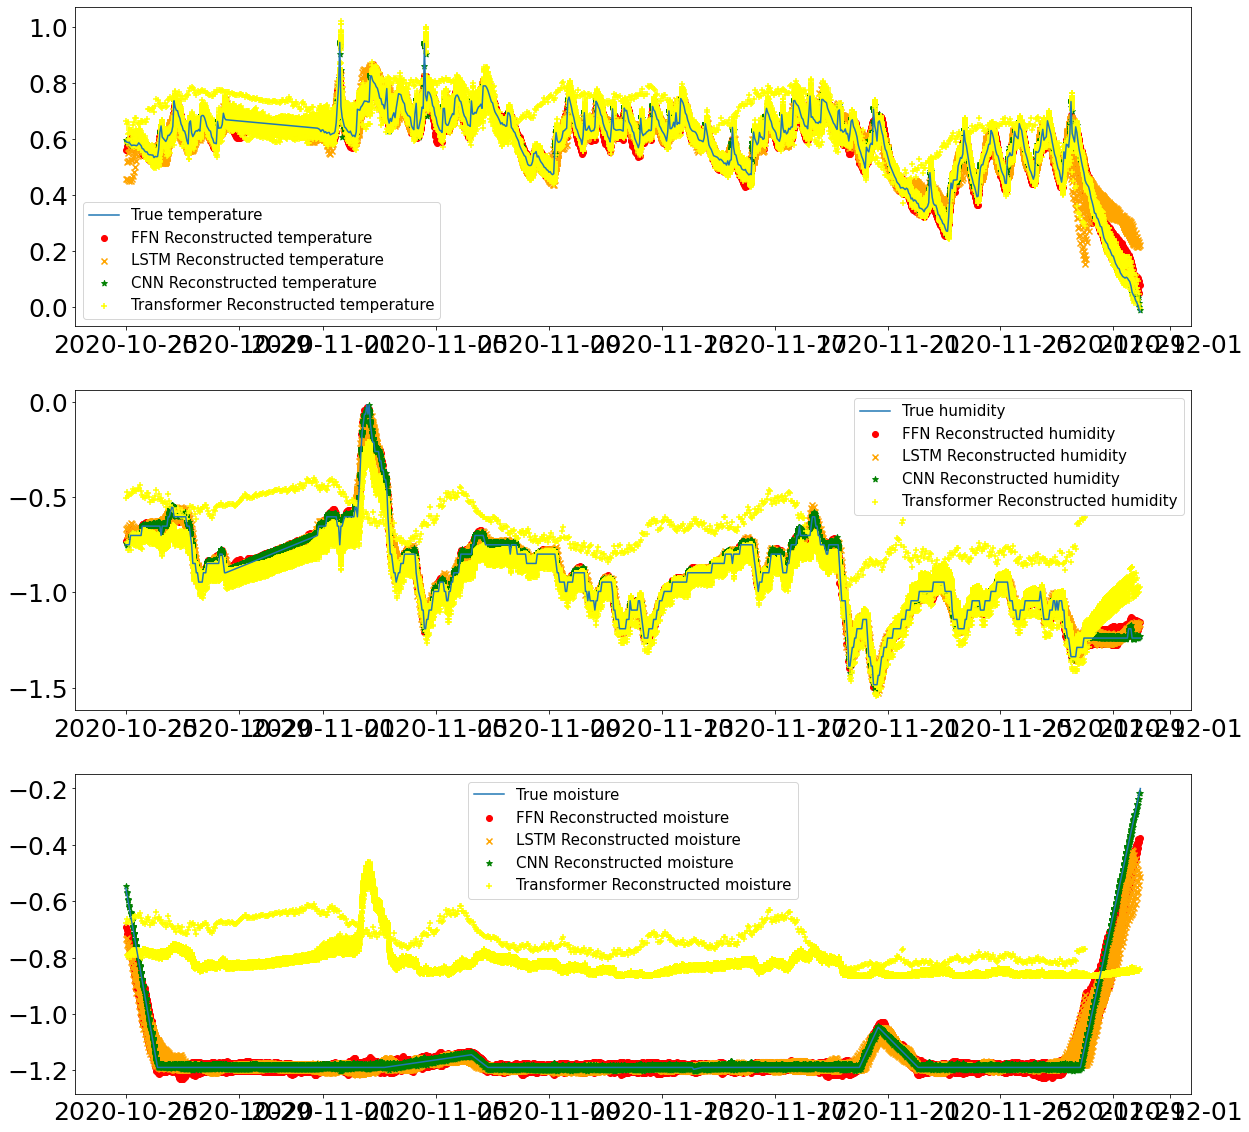

In [ ]:
#Plot reconstructions

#test_sensors = [20, 25, 26, 27, 50, 51, 12, 42, 17]
#20: "2020-09-15T00:00:00"-"2020-09-21T00:00:00", "2020-10-07T00:00:00"-"2020-10-15T00:00:00", 
#25: "2020-10-21T00:00:00"-"2020-11-30T00:00:00", 
#26: "2020-10-20T00:00:00"-"2020-11-30T00:00:00", 
#27: "2020-10-20T00:00:00"-"2020-11-30T00:00:00", 
#50: "2020-10-21T00:00:00"-"2020-11-30T00:00:00", 
#51: "2020-10-19T00:00:00"-"2020-11-30T00:00:00"
plot_idx = 8

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (20,20))
_ = ax[0].scatter(timestamps[plot_idx].T,predictionsFFN[plot_idx][:,:,0].T, marker='o', color='red', label ='FFN Reconstructed temperature')
_ = ax[0].scatter(timestamps[plot_idx].T,predictionsLSTM[plot_idx][:,:,0].T, marker='x', color='orange', label ='LSTM Reconstructed temperature')
_ = ax[0].scatter(timestamps[plot_idx].T,predictionsCNN[plot_idx][:,:,0].T, marker='*', color='green', label ='CNN Reconstructed temperature')
_ = ax[0].scatter(timestamps[plot_idx].T,predictionsTrans[plot_idx][:,:,0].T, marker='+', color='yellow', label ='Transformer Reconstructed temperature')
_ = ax[0].plot(data_full[plot_idx][:,1],data_full[plot_idx][:,2],label='True temperature')
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys(),fontsize=15)

_ = ax[1].scatter(timestamps[plot_idx].T,predictionsFFN[plot_idx][:,:,1].T, marker='o', color='red', label ='FFN Reconstructed humidity')
_ = ax[1].scatter(timestamps[plot_idx].T,predictionsLSTM[plot_idx][:,:,1].T, marker='x', color='orange', label ='LSTM Reconstructed humidity')
_ = ax[1].scatter(timestamps[plot_idx].T,predictionsCNN[plot_idx][:,:,1].T, marker='*', color='green', label ='CNN Reconstructed humidity')
_ = ax[1].scatter(timestamps[plot_idx].T,predictionsTrans[plot_idx][:,:,1].T, marker='+', color='yellow', label ='Transformer Reconstructed humidity')
_ = ax[1].plot(data_full[plot_idx][:,1],data_full[plot_idx][:,3],label='True humidity')
handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(),fontsize=15)

_ = ax[2].scatter(timestamps[plot_idx].T,predictionsFFN[plot_idx][:,:,2].T, marker='o', color='red', label ='FFN Reconstructed moisture')
_ = ax[2].scatter(timestamps[plot_idx].T,predictionsLSTM[plot_idx][:,:,2].T, marker='x', color='orange', label ='LSTM Reconstructed moisture')
_ = ax[2].scatter(timestamps[plot_idx].T,predictionsCNN[plot_idx][:,:,2].T, marker='*', color='green', label ='CNN Reconstructed moisture')
_ = ax[2].scatter(timestamps[plot_idx].T,predictionsTrans[plot_idx][:,:,2].T, marker='+', color='yellow', label ='Transformer Reconstructed moisture')
_ = ax[2].plot(data_full[plot_idx][:,1],data_full[plot_idx][:,5],label='True moisture')
handles, labels = ax[2].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[2].legend(by_label.values(), by_label.keys(),fontsize=15)

fname = plot_path + 'reconstructionsSensor' + str(test_sensors[plot_idx]) + '.png'
plt.savefig(fname)

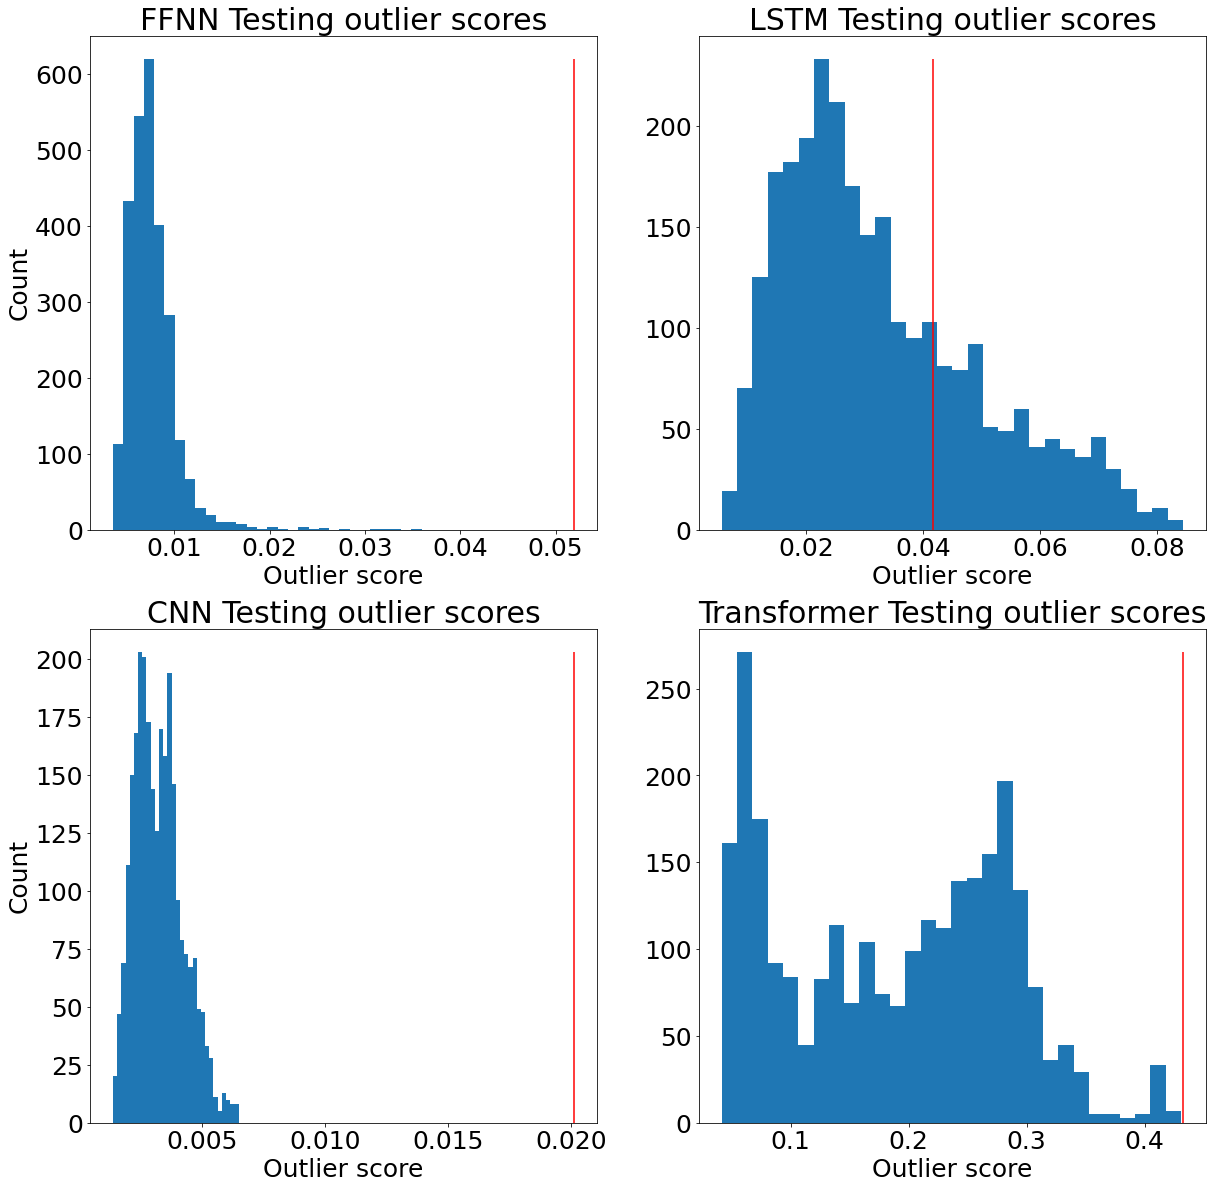

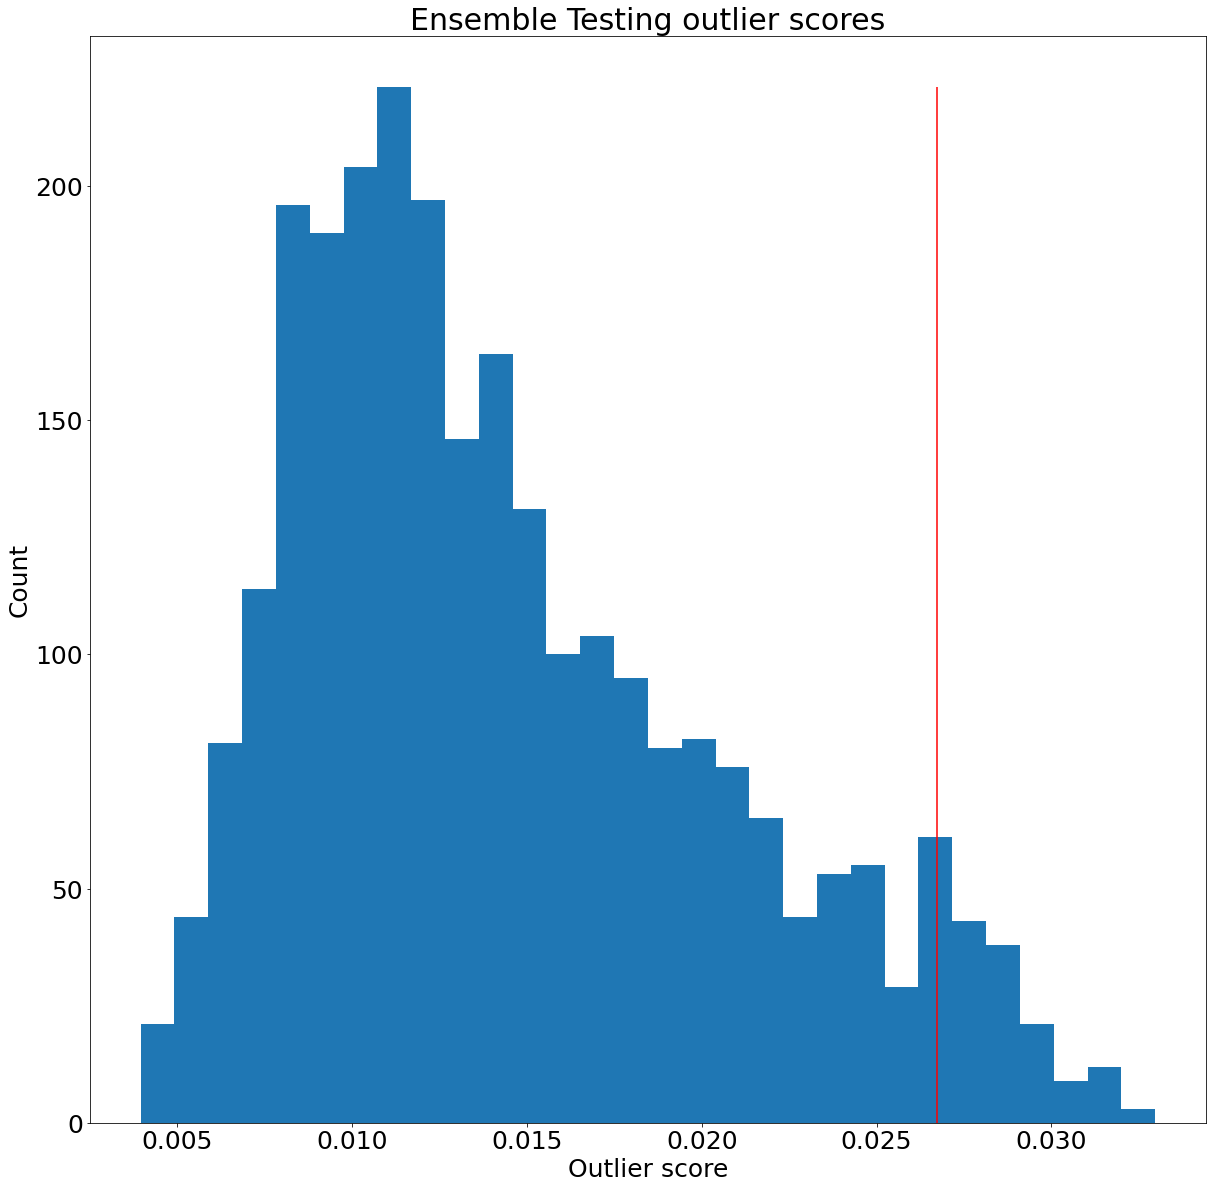

In [ ]:
plot_idx = 7

#Plot loss histograms
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

countsFFN, _, _ = ax[0][0].hist(lossesFFN[plot_idx], bins=30)
ax[0][0].vlines(threshold_FFN,0,np.max(countsFFN),colors='r')
ax[0][0].set_xlabel("Outlier score")
ax[0][0].set_ylabel("Count")
ax[0][0].set_title("FFNN Testing outlier scores")
countsLSTM, _, _ = ax[0][1].hist(lossesLSTM[plot_idx], bins=30)
ax[0][1].vlines(threshold_LSTM,0,np.max(countsLSTM),colors='r')
ax[0][1].set_xlabel("Outlier score")
ax[0][1].set_title("LSTM Testing outlier scores")
countsCNN, _, _ = ax[1][0].hist(lossesCNN[plot_idx], bins=30)
ax[1][0].vlines(threshold_CNN,0,np.max(countsCNN),colors='r')
ax[1][0].set_xlabel("Outlier score")
ax[1][0].set_ylabel("Count")
ax[1][0].set_title("CNN Testing outlier scores")
countsTrans, _, _ = ax[1][1].hist(lossesTrans[plot_idx], bins=30)
ax[1][1].vlines(threshold_Trans,0,np.max(countsTrans),colors='r')
ax[1][1].set_xlabel("Outlier score")
ax[1][1].set_title("Transformer Testing outlier scores")

#fname = plot_path + 'outlierScoresMembersSensor' + str(test_sensors[plot_idx]) + '.png'
#plt.savefig(fname)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,20))
counts, _, _ = ax.hist(lossesEnsemble[plot_idx], bins=30)
ax.vlines(threshold_Ensemble,0,np.max(counts),colors='r')
ax.set_xlabel("Outlier score")
ax.set_ylabel("Count")
ax.set_title("Ensemble Testing outlier scores")

fname = plot_path + 'outlierScoresEnsembleSensor' + str(test_sensors[plot_idx]) + 'QuantileThreshold.png'
plt.savefig(fname)

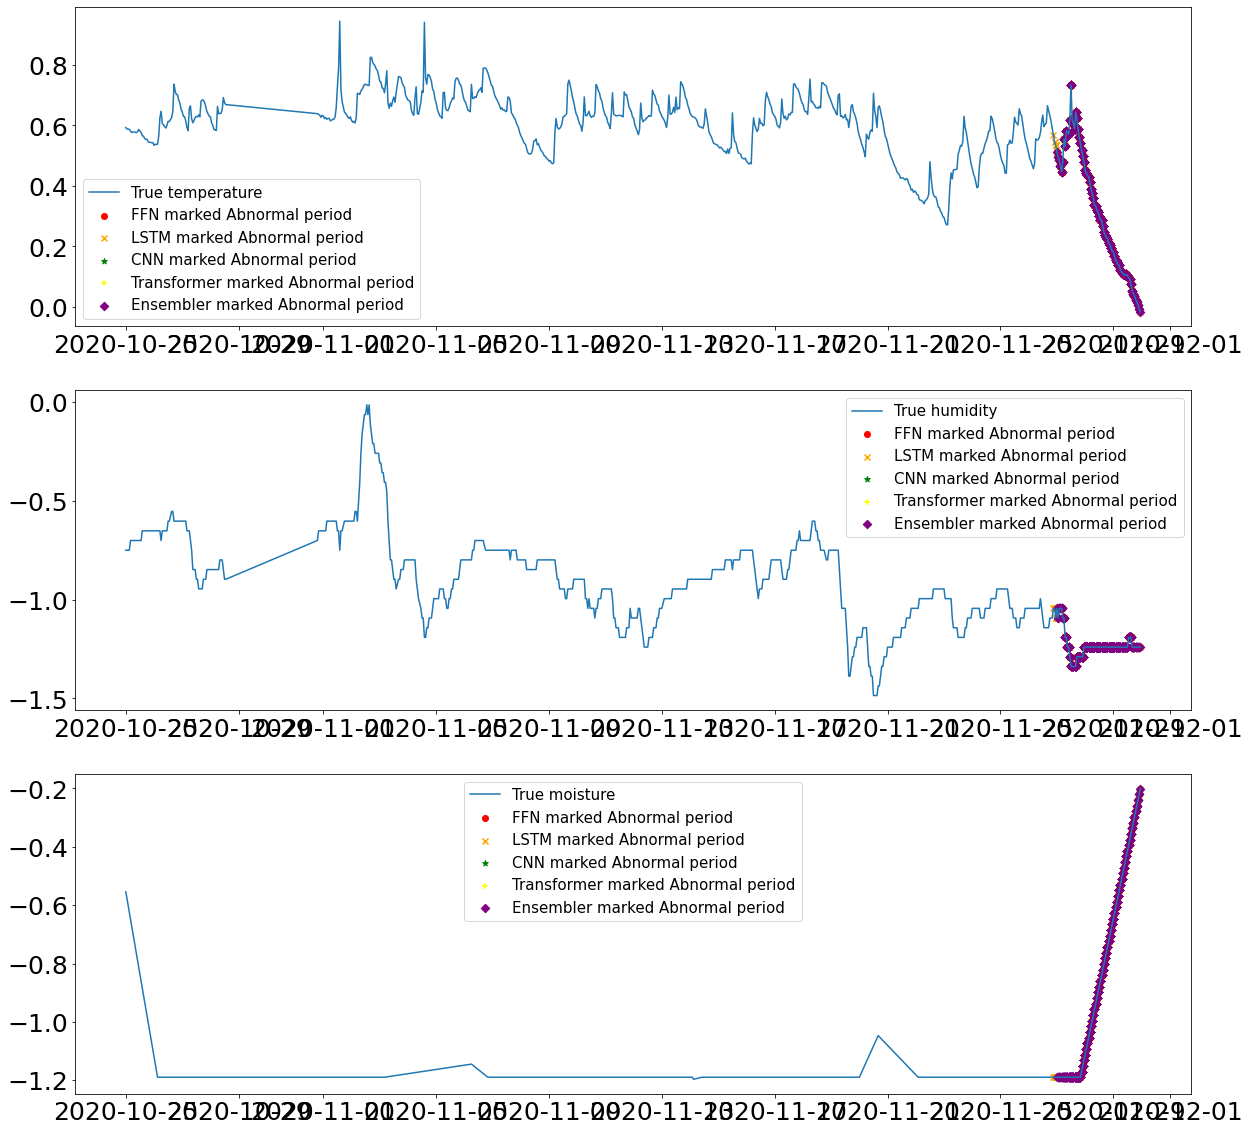

In [ ]:
#Plot anomalous periods

#test_sensors = [20, 25, 26, 27, 50, 51, 12, 42, 17]
#20: "2020-09-15T00:00:00"-"2020-09-21T00:00:00", "2020-10-07T00:00:00"-"2020-10-15T00:00:00", 
#25: "2020-10-21T00:00:00"-"2020-11-30T00:00:00", 
#26: "2020-10-20T00:00:00"-"2020-11-30T00:00:00", 
#27: "2020-10-20T00:00:00"-"2020-11-30T00:00:00", 
#50: "2020-10-21T00:00:00"-"2020-11-30T00:00:00", 
#51: "2020-10-19T00:00:00"-"2020-11-30T00:00:00"
plot_idx = 8

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (20,20))
_ = ax[0].scatter(timestamps[plot_idx][anomaliesFFN[plot_idx]].T,data_temporalize[plot_idx][anomaliesFFN[plot_idx],:,2].T, marker='o',color='red',label='FFN marked Abnormal period')
_ = ax[0].scatter(timestamps[plot_idx][anomaliesLSTM[plot_idx]].T,data_temporalize[plot_idx][anomaliesLSTM[plot_idx],:,2].T, marker='x',color='orange',label='LSTM marked Abnormal period')
_ = ax[0].scatter(timestamps[plot_idx][anomaliesCNN[plot_idx]].T,data_temporalize[plot_idx][anomaliesCNN[plot_idx],:,2].T, marker='*',color='green',label='CNN marked Abnormal period')
_ = ax[0].scatter(timestamps[plot_idx][anomaliesTrans[plot_idx]].T,data_temporalize[plot_idx][anomaliesTrans[plot_idx],:,2].T, marker='+',color='yellow',label='Transformer marked Abnormal period')
_ = ax[0].scatter(timestamps[plot_idx][anomaliesEnsemble[plot_idx]].T,data_temporalize[plot_idx][anomaliesEnsemble[plot_idx],:,2].T, marker='D',color='purple',label='Ensembler marked Abnormal period')
_ = ax[0].plot(data_full[plot_idx][:,1],data_full[plot_idx][:,2],label='True temperature')
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys(),fontsize=15)

_ = ax[1].scatter(timestamps[plot_idx][anomaliesFFN[plot_idx]].T,data_temporalize[plot_idx][anomaliesFFN[plot_idx],:,3].T, marker='o',color='red',label='FFN marked Abnormal period')
_ = ax[1].scatter(timestamps[plot_idx][anomaliesLSTM[plot_idx]].T,data_temporalize[plot_idx][anomaliesLSTM[plot_idx],:,3].T, marker='x',color='orange',label='LSTM marked Abnormal period')
_ = ax[1].scatter(timestamps[plot_idx][anomaliesCNN[plot_idx]].T,data_temporalize[plot_idx][anomaliesCNN[plot_idx],:,3].T, marker='*',color='green',label='CNN marked Abnormal period')
_ = ax[1].scatter(timestamps[plot_idx][anomaliesTrans[plot_idx]].T,data_temporalize[plot_idx][anomaliesTrans[plot_idx],:,3].T, marker='+',color='yellow',label='Transformer marked Abnormal period')
_ = ax[1].scatter(timestamps[plot_idx][anomaliesEnsemble[plot_idx]].T,data_temporalize[plot_idx][anomaliesEnsemble[plot_idx],:,3].T, marker='D',color='purple',label='Ensembler marked Abnormal period')
_ = ax[1].plot(data_full[plot_idx][:,1],data_full[plot_idx][:,3],label='True humidity')
handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(),fontsize=15)

_ = ax[2].scatter(timestamps[plot_idx][anomaliesFFN[plot_idx]].T,data_temporalize[plot_idx][anomaliesFFN[plot_idx],:,5].T, marker='o',color='red',label='FFN marked Abnormal period')
_ = ax[2].scatter(timestamps[plot_idx][anomaliesLSTM[plot_idx]].T,data_temporalize[plot_idx][anomaliesLSTM[plot_idx],:,5].T, marker='x',color='orange',label='LSTM marked Abnormal period')
_ = ax[2].scatter(timestamps[plot_idx][anomaliesCNN[plot_idx]].T,data_temporalize[plot_idx][anomaliesCNN[plot_idx],:,5].T, marker='*',color='green',label='CNN marked Abnormal period')
_ = ax[2].scatter(timestamps[plot_idx][anomaliesTrans[plot_idx]].T,data_temporalize[plot_idx][anomaliesTrans[plot_idx],:,5].T, marker='+',color='yellow',label='Transformer marked Abnormal period')
_ = ax[2].scatter(timestamps[plot_idx][anomaliesEnsemble[plot_idx]].T,data_temporalize[plot_idx][anomaliesEnsemble[plot_idx],:,5].T, marker='D',color='purple',label='Ensembler marked Abnormal period')
_ = ax[2].plot(data_full[plot_idx][:,1],data_full[plot_idx][:,5],label='True moisture')
handles, labels = ax[2].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[2].legend(by_label.values(), by_label.keys(),fontsize=15)

fname = plot_path + 'abnormalPeriodsSensor' + str(test_sensors[plot_idx]) + 'QuantileThreshold.png'
plt.savefig(fname)

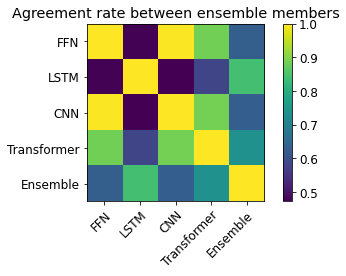

In [ ]:
plt.rcParams.update({'font.size': 12}) 

#Fraction of time windows where the ensemble members disagree
anomalies = [
  np.concatenate(anomaliesFFN), 
  np.concatenate(anomaliesLSTM), 
  np.concatenate(anomaliesCNN), 
  np.concatenate(anomaliesTrans), 
  np.concatenate(anomaliesEnsemble)
]

methods = ["FFN", "LSTM", "CNN", "Transformer", "Ensemble"]

c = np.zeros((len(anomalies),len(anomalies)))

for i, ano_i in enumerate(anomalies):
  for j, ano_j in enumerate(anomalies):
    c[i,j] = np.mean(ano_i == ano_j)

fig, ax = plt.subplots()
im = ax.imshow(c)

# We want to show all ticks...
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(methods)))
# ... and label them with the respective list entries
ax.set_xticklabels(methods)
ax.set_yticklabels(methods)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_title("Agreement rate between ensemble members")
fig.tight_layout()
fname = plot_path + 'agreementRateQuantileThreshold.png'
plt.savefig(fname)
plt.show()

plt.rcParams.update({'font.size': 25}) 

# Plotting

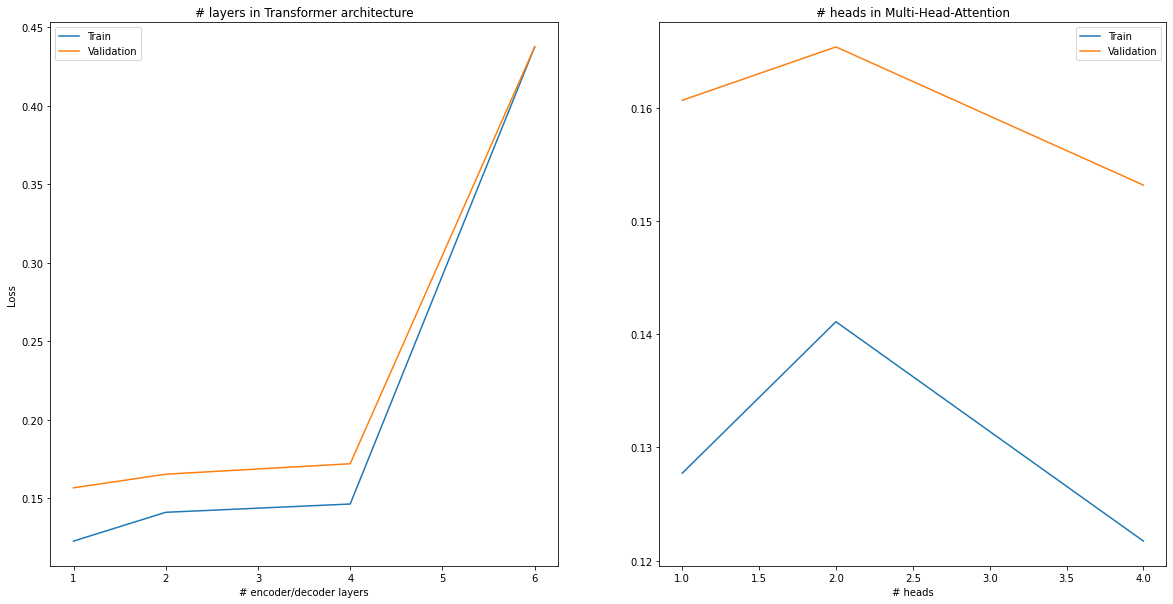

In [ ]:
files = ['historyTrans1layer', 'historyTrans2layers', 'historyTrans4layers', 'historyTrans6layer', 'historyTrans1head', 'historyTrans2layers', 'historyTrans4heads'];
val_losses = []
train_losses = []

for file in files:
  with open(model_path + file +  '.pkl', 'rb') as f:
      history = pickle.load(f)
      idx = np.argmin(history['val'])
      val_losses.append(history['val'][idx])
      train_losses.append(history['train'][idx])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
ax[0].plot([1, 2, 4, 6],train_losses[0:4],label='Train')
ax[0].plot([1, 2, 4, 6],val_losses[0:4],label='Validation')
ax[0].set_title('# layers in Transformer architecture')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('# encoder/decoder layers')
ax[0].legend()

ax[1].plot([1, 2, 4],train_losses[4:7],label='Train')
ax[1].plot([1, 2, 4],val_losses[4:7],label='Validation')
ax[1].set_title('# heads in Multi-Head-Attention')
ax[1].set_xlabel('# heads')
ax[1].legend()